In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
import os
import numpy as np
import datetime
import re
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import Dot, LSTM, Bidirectional, Reshape,Flatten
#from keras.layers.core import Dense
from keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D
pd.set_option("display.max_colwidth",None)
#pip install keras_nlp
#from keras_nlp.layers import PositionEmbedding

import pickle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
# This notebook shall train ML model for predicting resolution of alerts.
# ML model used are SVM , RF, XG Boost

In [0]:
# Example: load a DSS dataset as a Pandas dataframe
mydataset = dataiku.Dataset("comb_data_ind_final3")
df = mydataset.get_dataframe()

In [48]:
# Unseen processed data path - (August & September)
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
csv_path=os.path.join(folder_path,"Unseen_processed_data.csv")
df_test=pd.read_csv(csv_path)

# Data Quality & Descriptive stats info

try:
    df_test.drop("Unnamed: 0",axis=1,inplace=True)
except:
    pass
df_test=df_test.rename(columns={"NAME_MATCH_SCORE":"SIAMESE_MATCH_SCORE"})
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9462 entries, 0 to 9461
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   V_UCIF_ID                   9462 non-null   int64  
 1   N_WATCHLIST_PROFILE_ID      9462 non-null   int64  
 2   N_PARTY_WATCHLIST_MATCH_ID  9462 non-null   int64  
 3   D_CREATED_DTM               9462 non-null   object 
 4   V_CUST_DOB                  9462 non-null   object 
 5   V_DOB                       9462 non-null   object 
 6   V_DOB_2                     9462 non-null   object 
 7   V_WATCHLIST_DOB_2           9462 non-null   object 
 8   V_IC_DOB                    9462 non-null   object 
 9   V_COMMENTS                  9462 non-null   object 
 10  V_RESOLUTION                9462 non-null   int64  
 11  FINAL_DOB_MATCH             9462 non-null   float64
 12  DOB_MATCH_1                 9462 non-null   float64
 13  DOB_MATCH_2                 9462 

# Feature -1,2 (DOB,Age)

In [8]:
#mydataset = dataiku.Dataset("df_dob_results")
#df_dob_results = mydataset.get_dataframe()

folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_of_csv=os.path.join(folder_path,"DOB_results.csv")
df_dob=pd.read_csv(path_of_csv)

In [9]:
try :
    df_dob.drop("Unnamed: 0",axis=1,inplace=True)
except:
    df_dob

In [10]:
#df_final=df[["Index","V_UCIF_ID","N_WATCHLIST_PROFILE_ID","N_PARTY_WATCHLIST_MATCH_ID","D_CREATED_DTM"]].merge(df_dob_results_1,how='inner',on="Index")

In [40]:
df_dob[["N_PARTY_WATCHLIST_MATCH_ID","FINAL_DOB_MATCH","V_RESOLUTION","V_COMMENTS",]]

N_PARTY_WATCHLIST_MATCH_ID  FINAL_DOB_MATCH V_RESOLUTION                                                                                                                                                                                                                                                                                                                                                   V_COMMENTS
0                          1087675              0.6           FP                                                                                                                                                                                                                                                                                                                                    Mismatch ID number_NRIC\n
1                           613373             -1.0           TH                                                                                                                                                                                                                                                                                                                                                          NaN
2                           468202              1.0           TH                                                                                                                                                                                                                                                                                                                                                          NaN
3                           564574              0.0           FP                                                                                                                                                                                                                                                                                                                                      Mismatch ID number_NRIC
4                           640675              0.0           FP                                                                                                                                                                                                                                                                                                                                      Mismatch ID Number_NRIC
...                            ...              ...          ...                                                                                                                                                                                                                                                                                                                                                          ...
701176                     7565857             -1.0           FP                                                                                                                                                                                                                                                                                                     Mismatch Full Legal Name – Name Does Not Sound Similar\n
701177                     7565813             -1.0           FP                                                                                                                                                                                      Mismatch Father's Name - Difference in Father's Name. Comparison was made between customer’s official document (passport in UCO) against watchperson info. Refer to UCO
701178                     7565831             -1.0           FP                            Mismatch Father's Name - Difference in Father's Name\nCustomer (EDMS): IQBAL\nWatchperson (World Check): Muhammad Ajmal\nLink: https://edmsfilenet.maybank.com.my/WorkplaceBFE/getContent?obje

# Feature -3 (ID)

In [12]:
import os
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
csv_path=os.path.join(folder_path,"Id_ind_similarity_score .csv")

df_id=pd.read_csv(csv_path)
try:
    df_id.drop("Unnamed: 0",axis=1,inplace=True)
except:
    df_id 

In [13]:
df_id["ID_score"]=df_id["final_sc"].apply(lambda x: 1-x if x!=-1 else x)

In [14]:
df_id["ID_score"].value_counts()

-1.000000    308572
 0.000000    295893
 1.000000     91513
 0.916667      2557
 0.750000      1291
 0.833333       589
 0.888889       331
 0.875000       128
 0.950000        88
 0.300000        59
 0.900000        40
 0.285714        22
 0.850000        16
 0.625000        11
 0.857143        10
 0.350000         9
 0.400000         7
 0.950000         7
 0.666667         6
 0.777778         6
 0.900000         4
 0.818182         3
 0.800000         3
 0.714286         3
 0.342857         3
 0.857143         3
 0.500000         2
 0.909091         2
 0.111111         1
 0.375000         1
 0.529412         1
Name: ID_score, dtype: int64

In [15]:
print(df_id.columns)
df_id[['N_PARTY_WATCHLIST_MATCH_ID', 'V_UCIF_ID', 'N_WATCHLIST_PROFILE_ID', 'al_wl_ids', 'cust_id_all_sp_accom', 'trans_agg_v_id_type', 'score1', 'final_sc', 'ID_score']]

Index(['N_PARTY_WATCHLIST_MATCH_ID', 'V_UCIF_ID', 'N_WATCHLIST_PROFILE_ID', 'al_wl_ids', 'cust_id_all_sp_accom', 'trans_agg_v_id_type', 'score1', 'final_sc', 'ID_score'], dtype='object')


N_PARTY_WATCHLIST_MATCH_ID  V_UCIF_ID  N_WATCHLIST_PROFILE_ID                     al_wl_ids                     cust_id_all_sp_accom       trans_agg_v_id_type                                                               score1  final_sc  ID_score
0                          1087675  144414189                 4744018   ['4975714', '560515016155']              ['5069449', '561009106435']            ['DD', 'NWIC']     {'exact_m': [], 'substring_m': [], 'leven_m': [], 'ic_m': [1.0]}     1.000     0.000
1                           613373   55620697                 4744620   ['8187206', '581022715065']                             ['8187206B']                  ['OLIC']   {'exact_m': [], 'substring_m': [0.125], 'leven_m': [], 'ic_m': []}     0.125     0.875
2                           468202   29392926                 4745480              ['820220065759']                         ['820220065759']                  ['NWIC']  {'exact_m': [0.0], 'substring_m': [], 'leven_m': [], 'ic_m': [0.0]}     0.000     1.000
3                           564574   46555700                 4745566  ['H0653122', '650705125060']                         ['780416025202']                  ['NWIC']     {'exact_m': [], 'substring_m': [], 'leven_m': [], 'ic_m': [1.0]}     1.000     0.000
4                           640675   60519764                 4745566  ['H0653122', '650705125060']              ['481030075418', '0302481']            ['NWIC', 'DD']     {'exact_m': [], 'substring_m': [], 'leven_m': [], 'ic_m': [1.0]}     1.000     0.000
...                            ...        ...                     ...                           ...                                      ...                       ...                                                                  ...       ...       ...
701176                     7565857   73564041                15297593             ['3660266701349']                            ['BG2221731']                  ['PASS']        {'exact_m': [], 'substring_m': [], 'leven_m': [], 'ic_m': []}     1.000     0.000
701177                     7565813  165957449                15297593             ['3660266701349']    ['BT2223464', 'EP100113602143242236']          ['PASS', 'WVSA']        {'exact_m': [], 'substring_m': [], 'leven_m': [], 'ic_m': []}     1.000     0.000
701178                     7565831  171460014                15297593             ['3660266701349']               ['AZ2296622', 'PF5455489']          ['PASS', 'WVSA']        {'exact_m': [], 'substring_m': [], 'leven_m': [], 'ic_m': []}     1.000     0.000
701179                     7565871   52438134                15301291                           NaN  ['PF2798144', 'TH8030382', 'TZ1262181']  ['DVSA', 'PASS', 'PASS']                                                either ID not present    -1.000    -1.000
701180                     7570204  170924898                15305333                           NaN               ['E68301669', 'PF5438447']          ['PASS', 'SVSA']                                                either ID not present    -1.000    -1.000

[701181 rows x 9 columns]

In [16]:
df=pd.merge(df_dob,df_id[['N_PARTY_WATCHLIST_MATCH_ID','ID_score','al_wl_ids', 'cust_id_all_sp_accom', 'trans_agg_v_id_type', 'score1']],how="left",on="N_PARTY_WATCHLIST_MATCH_ID")

In [41]:
df[["N_PARTY_WATCHLIST_MATCH_ID","FINAL_DOB_MATCH","ID_score","V_RESOLUTION","V_COMMENTS"]]

N_PARTY_WATCHLIST_MATCH_ID  FINAL_DOB_MATCH  ID_score V_RESOLUTION                                                                                                                                                                                                                                                                                                                                                   V_COMMENTS
0                          1087675              0.6     0.000           FP                                                                                                                                                                                                                                                                                                                                    Mismatch ID number_NRIC\n
1                           613373             -1.0     0.875           TH                                                                                                                                                                                                                                                                                                                                                          NaN
2                           468202              1.0     1.000           TH                                                                                                                                                                                                                                                                                                                                                          NaN
3                           564574              0.0     0.000           FP                                                                                                                                                                                                                                                                                                                                      Mismatch ID number_NRIC
4                           640675              0.0     0.000           FP                                                                                                                                                                                                                                                                                                                                      Mismatch ID Number_NRIC
...                            ...              ...       ...          ...                                                                                                                                                                                                                                                                                                                                                          ...
701176                     7565857             -1.0     0.000           FP                                                                                                                                                                                                                                                                                                     Mismatch Full Legal Name – Name Does Not Sound Similar\n
701177                     7565813             -1.0     0.000           FP                                                                                                                                                                                      Mismatch Father's Name - Difference in Father's Name. Comparison was made between customer’s official document (passport in UCO) against watchperson info. Refer to UCO
701178                     7565831             -1.0     0.000           FP                            Mismatch Father's Name - Difference in Father's Name\nCustomer (EDMS): IQBAL\nWatchperson 

# Feature -4 ( Name)

In [4]:
# Example: load a DSS dataset as a Pandas dataframe
mydataset = dataiku.Dataset("comb_data_ind_final3")
df_combined = mydataset.get_dataframe()

In [5]:
df_new=df_combined.copy()
my_dataset = dataiku.Dataset("Standradization_rules_draft__base_line_model")
scr_rules = my_dataset.get_dataframe()

scr_rules.loc[46:51,"V_SCREENING_VALUE_1"]=scr_rules.loc[46:51,"V_SCREENING_VALUE_1"].apply(lambda x: x.lstrip("( ").rstrip(")"))

scr_rules_2=scr_rules.iloc[21:45,:] # Punctuation marks
scr_rules_3=scr_rules.iloc[46:52,:]  #  Standardization rules
scr_rules=scr_rules.iloc[0:16,:]    # patronym & honourary titles



df_new["V_COMMENTS"]=df_new["V_COMMENTS"].apply(lambda x: '' if pd.isna(x) else x)

# Customer Name 

df_new['V_PREVIOUS_NAME_1']=df_new['V_PREVIOUS_NAME_1'].apply(lambda x : [""]  if pd.isna(x) else [str(x).upper()])
df_new['V_PREVIOUS_NAME_2']=df_new['V_PREVIOUS_NAME_2'].apply(lambda x :  [""] if pd.isna(x) else [str(x).upper()])
df_new['V_PREVIOUS_NAME_IMMEDIATE']=df_new['V_PREVIOUS_NAME_IMMEDIATE'].apply(lambda x :  [""] if pd.isna(x) else [str(x).upper()])


# pre-processing on "V_REGD_PARTY_NAME"

df_new["V_REGD_PARTY_NAME"]=df_new["V_REGD_PARTY_NAME"].apply(lambda x : [""]  if pd.isna(x) else [str(x).upper()])
# not more than element is present in V_REGD_PARTY_NAMES
df_new[df_new["V_REGD_PARTY_NAME"].apply(lambda x: len(x)>1)]

# imputation done
df_new[["V_REGD_PARTY_NAME", 'V_PREVIOUS_NAME_IMMEDIATE', 'V_PREVIOUS_NAME_1','V_PREVIOUS_NAME_2']]
name_df_new=pd.DataFrame({})
name_df_new["ALL_PARTY_NAMES"]=df_new[["V_REGD_PARTY_NAME", 'V_PREVIOUS_NAME_IMMEDIATE', 'V_PREVIOUS_NAME_1','V_PREVIOUS_NAME_2']].apply(lambda x: x[0]+x[1]+x[2]+x[3],axis=1)

# Patronym , ' - , Honourary Titles 
for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
    name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(k," ",x[0]),re.sub(k," ",x[1]),re.sub(k," ",x[2]),re.sub(k," ",x[3])])

#' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("\'","",x[0]),re.sub("\'","",x[1]),re.sub("\'","",x[2]),re.sub("\'","",x[3])])

# - dash
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("-"," ",x[0]),re.sub("-"," ",x[1]),re.sub("-"," ",x[2]),re.sub("-"," ",x[3])])


for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():

    name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("^("+k+")","",x[0]),re.sub("^("+k+")","",x[1]),re.sub("^("+k+")","",x[2]),re.sub("^("+k+")","",x[3])]) 
# We need to remove HAJI & all such terms if in case they come in b/w names.
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",i) for i in x])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",i) for i in x])


# Need to add a cap ^ to remove only the names where titles come as prefix.

# Pre-processing (Step-2) & getting Alias names
# () Alias name  -  below alias name 2 column, has list in each row.
name_df_new["V_ALIAS_NAME_2"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.findall("\(.+\)",x[i]) for i in range(len(x))])


name_df_new["V_ALIAS_NAME_2"]=name_df_new["V_ALIAS_NAME_2"].apply(lambda x: [x[i][0].lstrip("(").rstrip(")") if len(x[i])>0 else "" for i in range(len(x))])

name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(" \(.+\)","",x[i]) for i in range(len(x))])


#@ 
name_df_new["V_ALIAS_NAME_3"]=[""]*(df_new.shape[0])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.split("@",x[i]) for i in range(len(x))])

name_df_new["V_ALIAS_NAME_3"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [x[i][1].lstrip(" ") if len(x[i]) >1 else "" for i in range(len(x))])

name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply( lambda x: [x[i][0].rstrip(" ") for i in range(len(x)) ])



# slash - if more than one slash than issue shall arise
name_df_new["V_ALIAS_NAME_4"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.split(" / ",x[i]) for i in range(len(x))])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["V_ALIAS_NAME_4"].apply(lambda x:[x[i][0] for i in range(len(x))])
name_df_new["V_ALIAS_NAME_4"]=name_df_new["V_ALIAS_NAME_4"].apply(lambda x:[x[i][1] if len(x[i])>1 else "" for i in range(len(x))])


# Accented Characters
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Á,Ä,Â,Ã]","A",x[0]),re.sub("[Á,Ä,Â,Ã]","A",x[1]),re.sub("[Á,Ä,Â,Ã]","A",x[2]),re.sub("[Á,Ä,Â,Ã]","A",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Å]","AA",x[0]),re.sub("[Å]","AA",x[1]),re.sub("[Å]","AA",x[2]),re.sub("[Å]","AA",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[É,Ë,Ê,È]","E",x[0]),re.sub("[É,Ë,Ê,È]","E",x[1]),re.sub("[É,Ë,Ê,È]","E",x[2]),re.sub("[É,Ë,Ê,È]","E",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Í,Ï,Î]","I",x[0]),re.sub("[Í,Ï,Î]","I",x[1]),re.sub("[Í,Ï,Î]","I",x[2]),re.sub("[Í,Ï,Î]","I",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ó,Ô,Ö,Õ]","O",x[0]),re.sub("[Ó,Ô,Ö,Õ]","O",x[1]),re.sub("[Ó,Ô,Ö,Õ]","O",x[2]),re.sub("[Ó,Ô,Ö,Õ]","O",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ú,Ü,Ù]","U",x[0]),re.sub("[Ú,Ü,Ù]","U",x[1]),re.sub("[Ú,Ü,Ù]","U",x[2]),re.sub("[Ú,Ü,Ù]","U",x[3])])

name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ø]","OE",x[0]),re.sub("[Ø]","OE",x[1]),re.sub("[Ø]","OE",x[2]),re.sub("[Ø]","OE",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ç]","C",x[0]),re.sub("[Ç]","C",x[1]),re.sub("[Ç]","C",x[2]),re.sub("[Ç]","C",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ñ]","N",x[0]),re.sub("[Ñ]","N",x[1]),re.sub("[Ñ]","N",x[2]),re.sub("[Ñ]","N",x[3])])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("[Ý]","Y",x[0]),re.sub("[Ý]","Y",x[1]),re.sub("[Ý]","Y",x[2]),re.sub("[Ý]","Y",x[3])])


name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [i.replace(r"\xa0","") for i in x ]) 


name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [i.replace(r"\xa0","") for i in x ])
df_new["V_REGD_PARTY_NAME"]=df_new["V_REGD_PARTY_NAME"].apply(lambda x: x[0])

### Punctuation Marks

df_new[df_new["V_REGD_PARTY_NAME"].str.contains(",\s")]["V_REGD_PARTY_NAME"]
df_new[df_new["V_REGD_PARTY_NAME"].str.contains("\s+,\s+")]["V_REGD_PARTY_NAME"]

name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("\s+,\s+"," ",i) for i in x])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub("\s+,"," ",i) for i in x])
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(",\s+"," ",i) for i in x])



scr_rules_2
for j in scr_rules_2["V_SCREENING_VALUE_1"]:

    name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(j," ",x[i]) for i in range(len(x))])

### Standardized Names

for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])

# For any other miscellaneous character
name_df_new["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x))])

# V_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
name_df_new["GROUP_ALIAS_NAME_1"]=name_df_new[["V_ALIAS_NAME_2","V_ALIAS_NAME_3","V_ALIAS_NAME_4"]].apply(lambda x: x[0]+x[1]+x[2],axis=1)
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    #name_df_new["V_ALIAS_NAME_2"]=name_df_new["V_ALIAS_NAME_2"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])
    name_df_new["GROUP_ALIAS_NAME_1"]=name_df_new["GROUP_ALIAS_NAME_1"].apply(lambda x: [re.sub(str(i)," ",x[j]) for j in range(len(x))])

#Std Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    name_df_new["GROUP_ALIAS_NAME_1"]=name_df_new["GROUP_ALIAS_NAME_1"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


 # Miscellaneous character
name_df_new["GROUP_ALIAS_NAME_1"]=name_df_new["GROUP_ALIAS_NAME_1"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ])                                                                  

# Watch-list names Pre-processing

df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: "" if pd.isna(x) else x)

# Patronym , ' - , Honourary Titles 
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].str.upper()
for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
    df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(k," ",x))
#' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("\'","",x))
# - dash
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("-"," ",x))

for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():

    df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("^("+k+")","",x)) 

# We need to remove HAJI & all such terms if in case they come in b/w names.
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",x))


# Need to add a cap ^ to remove only the names where titles come as prefix.


# V_WATCHLIST_ALIAS_NAME
# using () - assuming that ( comes only for once)
df_new["V_WATCHLIST_ALIAS_NAME_2"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.findall("\(.+\)",x))
df_new["V_WATCHLIST_ALIAS_NAME_2"]=df_new["V_WATCHLIST_ALIAS_NAME_2"].apply(lambda x: x[0].lstrip("(").rstrip(")") if len(x)>0 else "" )

df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(" \(.+\)","",x))


#@ - assuming it comes only for once
df_new["V_WATCHLIST_ALIAS_NAME_3"]=[""]*(df_new.shape[0])
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.split("@",x))
df_new["V_WATCHLIST_ALIAS_NAME_3"]=df_new["V_PROFILE_NAME"].apply(lambda x: x[1].lstrip(" ") if len(x) >1 else "")
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply( lambda x: x[0].rstrip(" "))

# slash - assume that / can come several times & therefore we split .
df_new["V_WATCHLIST_ALIAS_NAME_4"]=[""]*(df_new.shape[0])
df_new["V_WATCHLIST_ALIAS_NAME_4"]=df_new["V_PROFILE_NAME"].str.split(" / ")
df_new["V_PROFILE_NAME"]=df_new["V_WATCHLIST_ALIAS_NAME_4"].apply(lambda x: x[0])
df_new["V_WATCHLIST_ALIAS_NAME_4"]=df_new["V_WATCHLIST_ALIAS_NAME_4"].apply(lambda x: x[1:2] if len(x)>1 else [])

# comma 
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("\s+,\s+"," ",x) )
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("\s+,"," ",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(",\s+"," ",x) )
#df_new["V_WATCHLIST_ALIAS_NAME_5"]=df_new["V_PROFILE_NAME"].apply(lambda x: x[1].lstrip(" ") if len(x) >1 else "")
#df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: x[0].rstrip(" "))


# Accented characters
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Á,Ä,Â,Ã]","A",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Å]","AA",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[É,Ë,Ê,È]","E",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Í,Ï,Î]","I",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ó,Ô,Ö,Õ]","O",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ú,Ü,Ù]","U",x))

df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ø]","OE",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ç]","C",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ñ]","N",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub("[Ý]","Y",x))
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].str.replace(r"\xa0","")                                                                                

# Punctuation Marks

#Punctuation Marks
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(i," ",x))

# Standardized Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x: re.sub(k[0],k[1],x))

# For any other miscellaneous character
df_new["V_PROFILE_NAME"]=df_new["V_PROFILE_NAME"].apply(lambda x : re.sub("[^A-Z\s ]+","",x))

# V_WATCHLIST_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new[["V_WATCHLIST_ALIAS_NAME_2","V_WATCHLIST_ALIAS_NAME_3","V_WATCHLIST_ALIAS_NAME_4"]].apply(lambda x: [x[0]]+[x[1]]+x[2],axis=1)
for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new["ALL_WL_NAMES_FROM_PROFILE"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])

#Std Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new["ALL_WL_NAMES_FROM_PROFILE"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


 # Miscellaneous character
df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new["ALL_WL_NAMES_FROM_PROFILE"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ])                                                               

print("V_ALIASES started")


df_new["ALL_WL_NAMES_FROM_PROFILE"]=df_new[["ALL_WL_NAMES_FROM_PROFILE","V_PROFILE_NAME"]].apply(lambda x: x[0]+[x[1]],axis=1)

# WL Alias Name

# Alias name
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: "" if pd.isna(x) else str(x))
df_new["V_ALIASES"]=df_new["V_ALIASES"].str.upper()

df_new[df_new["V_ALIASES"].str.contains(";")]["V_ALIASES"]


# need to split several names
df_new["V_ALIASES"]=df_new["V_ALIASES"].str.split(";")

# removal of comma with white space character
#df_new["V_ALIASES"]=df_new["V_ALIASES"].apply (lambda x: [re.sub(","," ",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("\s+,\s+"," ",i) for i in x])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("\s+,"," ",i) for i in x])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(",\s+"," ",i) for i in x])

df_new[df_new["V_ALIASES"].apply(lambda x: type(x)==float)]["V_ALIASES"]

# Patronym , ' - , Honourary Titles 
for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
    df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(k," ",x[i]) for i in range(len(x))])
#' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("\'","",x[i]) for i in range(len(x))])
# - dash
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("-"," ",x[i]) for i in range(len(x))])

for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():

    df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("^("+k+")","",x[i]) for i in range(len(x))]) 

# We need to remove HAJI & all such terms if in case they come in b/w names.
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",x[i]) for i in range(len(x))])


# Need to add a cap ^ to remove only the names where titles come as prefix.


# V_WATCHLIST_ALIAS_NAME
# using ()
df_new["V_WATCHLIST_ALIAS_NAME_5"]=df_new["V_ALIASES"].apply(lambda x: [re.findall("\(.+\)",x[i]) for i in range(len(x))])
df_new["V_WATCHLIST_ALIAS_NAME_5"]=df_new["V_WATCHLIST_ALIAS_NAME_5"].apply(lambda x: [x[i][0].lstrip("(").rstrip(")") if len(x[i])>0 else ""  for i in range(len(x))])

df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(" \(.+\)","",x[i]) for i in range(len(x))])


#@ 
df_new["V_WATCHLIST_ALIAS_NAME_6"]=[""]*(df_new.shape[0])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.split("@",x[i]) for i in range(len(x))])
df_new["V_WATCHLIST_ALIAS_NAME_6"]=df_new["V_ALIASES"].apply(lambda x: [x[i][1].lstrip(" ") if len(x[i]) >1 else "" for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply( lambda x: [x[i][0].rstrip(" ") for i in range(len(x))])

# slash
df_new["V_WATCHLIST_ALIAS_NAME_7"]=[""]*(df_new.shape[0])
df_new["V_WATCHLIST_ALIAS_NAME_7"]=df_new["V_ALIASES"].apply(lambda x: [re.split(" / ",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_WATCHLIST_ALIAS_NAME_7"].apply(lambda x: [x[i][0]  for i in range(len(x))])
df_new["V_WATCHLIST_ALIAS_NAME_7"]=df_new["V_WATCHLIST_ALIAS_NAME_7"].apply(lambda x:[x[i][1] if len(x[i])>=2 else '' for i in range(len(x))])




# Accented characters
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Á,Ä,Â,Ã]","A",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Å]","AA",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[É,Ë,Ê,È]","E",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Í,Ï,Î]","I",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ó,Ô,Ö,Õ]","O",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ú,Ü,Ù]","U",x[i]) for i in range(len(x))])

df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ø]","OE",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ç]","C",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ñ]","N",x[i]) for i in range(len(x))])
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub("[Ý]","Y",x[i]) for i in range(len(x))])


df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [i.replace(r"\xa0","") for i in x ])

# Punctuation Marks

#Punctuation Marks
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])

# Standardized Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x: [re.sub(k[0],k[1],x[i])  for i in range(len(x))])

# For any other miscellaneous character
df_new["V_ALIASES"]=df_new["V_ALIASES"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x))])

# V_WATCHLIST_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
all_wl_nam=pd.DataFrame({})
all_wl_nam["ALL_WL_ALIAS_NAMES"]= df_new[["V_WATCHLIST_ALIAS_NAME_5","V_WATCHLIST_ALIAS_NAME_6","V_WATCHLIST_ALIAS_NAME_7"]].apply(lambda x: \
                                                                                                x[0]+x[1]+x[2],axis=1 )
all_wl_nam["V_ALIASES"]=df_new["V_ALIASES"].values 

for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    all_wl_nam["ALL_WL_ALIAS_NAMES"]=all_wl_nam["ALL_WL_ALIAS_NAMES"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])

#Std Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    all_wl_nam["ALL_WL_ALIAS_NAMES"]=all_wl_nam["ALL_WL_ALIAS_NAMES"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


# Miscellaneous character
all_wl_nam["ALL_WL_ALIAS_NAMES"]=all_wl_nam["ALL_WL_ALIAS_NAMES"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ]   )                                                               


all_wl_nam["ALL_WL_ALIAS_NAMES"]= all_wl_nam[["V_ALIASES","ALL_WL_ALIAS_NAMES"]].apply(lambda x: \
                                                                                                            x[0]+x[1],axis=1 )


all_wl_nam["ALL_WL_NAMES_FROM_PROFILE"]=df_new["ALL_WL_NAMES_FROM_PROFILE"].values

all_wl_nam["ALL_WL_NAMES"]=all_wl_nam[["ALL_WL_ALIAS_NAMES","ALL_WL_NAMES_FROM_PROFILE"]].apply(lambda x: x[0]+x[1],axis=1)
print("WL Names ended")
# Alias name 

# pre-processing on 'V_ALIAS_NAME' from customer
df_new['V_ALIAS_NAME']=df_new['V_ALIAS_NAME'].apply(lambda x: "" if pd.isna(x) else str(x).upper())

# Patronym , ' - , Honourary Titles 
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].str.upper()
for k in [' A/L | A/P | S/O | D/O | SO | DO | AP ',' BINTI | BINTE | B | BTE | BT | IBNI | IBNU | ANAK ']:  # if any patronym title comes , then remove it 
    df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(k," ",x))
#' apostrophe Abd Alfattah So'ud Abd Alfattah DARDAS
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("\'","",x))
# - dash
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("-"," ",x))

for k in scr_rules["V_SCREENING_VALUE_1"].values[4:16].tolist():

    df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("^("+k+")","",x)) 

# We need to remove HAJI & all such terms if in case they come in b/w names.
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(" HAJI | HAJJAH | HAJAH | HJH | HJ | ALHAJ | HADJI "," ",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("( HAJI| HAJJAH| HAJAH| HJH| HJ| ALHAJ| HADJI)$","",x))


# Need to add a cap ^ to remove only the names where titles come as prefix.


# ALIAS_NAME
# using () - considering () only comes for once
df_new["V_ALIAS_NAME_5"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.findall("\(.+\)",x))
df_new["V_ALIAS_NAME_5"]=df_new["V_ALIAS_NAME_5"].apply(lambda x: x[0].lstrip("(").rstrip(")") if len(x)>0 else "" )

df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(" \(.+\)","",x))


#@ assuming @ comes only for once
df_new["V_ALIAS_NAME_6"]=[""]*(df_new.shape[0])
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.split("@",x))
df_new["V_ALIAS_NAME_6"]=df_new["V_ALIAS_NAME"].apply(lambda x: x[1].lstrip(" ") if len(x) >1 else "")
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply( lambda x: x[0].rstrip(" "))

# slash - can come as many times as possible
df_new["V_ALIAS_NAME_7"]=[""]*(df_new.shape[0])
df_new["V_ALIAS_NAME_7"]=df_new["V_ALIAS_NAME"].str.split(" / ")
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME_7"].apply(lambda x: x[0])
df_new["V_ALIAS_NAME_7"]=df_new["V_ALIAS_NAME_7"].apply(lambda x: x[1] if len(x)>1 else "")

# comma ( create new alias name ) 
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("\s+,\s+"," ",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("\s+,"," ",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(",\s+"," ",x))

# Accented characters
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Á,Ä,Â,Ã]","A",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Å]","AA",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[É,Ë,Ê,È]","E",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Í,Ï,Î]","I",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ó,Ô,Ö,Õ]","O",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ú,Ü,Ù]","U",x))

df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ø]","OE",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ç]","C",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ñ]","N",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub("[Ý]","Y",x))
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(r"\xa0","",x))

#Punctuation Marks
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(i," ",x))

# Standardized Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x: re.sub(k[0],k[1],x))

# For any other miscellaneous character
df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].apply(lambda x : re.sub("[^A-Z\s ]+","",x))

# V_ALIAS_NAME - Punctuation mark , std names , miscellaneous character
name_df_new["GROUP_ALIAS_NAME_2"]=df_new[["V_ALIAS_NAME_5","V_ALIAS_NAME_6","V_ALIAS_NAME_7"]].apply(lambda x: [x[0],x[1],x[2]],axis=1)
name_df_new["V_ALIAS_NAME"]=df_new["V_ALIAS_NAME"].values
scr_rules_2
for i in scr_rules_2["V_SCREENING_VALUE_1"]:

    name_df_new["GROUP_ALIAS_NAME_2"]=name_df_new["GROUP_ALIAS_NAME_2"].apply(lambda x: [re.sub(i," ",x[j]) for j in range(len(x))])
#Std Names
for k in scr_rules_3[["V_SCREENING_VALUE_1","Solution"]].values:

    name_df_new["GROUP_ALIAS_NAME_2"]=name_df_new["GROUP_ALIAS_NAME_2"].apply(lambda x: [re.sub(k[0],k[1],x[i]) for i in range(len(x))])


 # Miscellaneous character
name_df_new["GROUP_ALIAS_NAME_2"]=name_df_new["GROUP_ALIAS_NAME_2"].apply(lambda x : [re.sub("[^A-Z\s ]+","",x[i]) for i in range(len(x)) ]  )      
name_df_new["GROUP_ALIAS_NAME_2"]=name_df_new[["V_ALIAS_NAME","GROUP_ALIAS_NAME_2"]].apply(lambda x: [x[0]]+x[1],axis=1)

# All customer Alias name
name_df_new["ALL_ALIAS_NAMES"]=name_df_new[["GROUP_ALIAS_NAME_1","GROUP_ALIAS_NAME_2"]].apply(lambda x: x[0]+x[1],axis=1)
df_to_match=pd.DataFrame({})
df_to_match["ALL_ALIAS_NAMES"]=name_df_new["ALL_ALIAS_NAMES"].values
df_to_match["ALL_PARTY_NAMES"]=name_df_new["ALL_PARTY_NAMES"].values
df_to_match["ALL_WL_NAMES"]=all_wl_nam["ALL_WL_NAMES"].values
df_to_match["V_COMMENTS"]=df_new["V_COMMENTS"].values
df_to_match["V_RESOLUTION"]=df_new["V_RESOLUTION"].values
df_to_match["N_MATCH_SCORE"]=df_new["N_MATCH_SCORE"].values
df_to_match["N_PARTY_WATCHLIST_MATCH_ID"]=df_new["N_PARTY_WATCHLIST_MATCH_ID"].values
df_to_match["V_UCIF_ID"]=df_new["V_UCIF_ID"].values
df_to_match["N_WATCHLIST_PROFILE_ID"]=df_new["N_WATCHLIST_PROFILE_ID"].values


V_ALIASES started
WL Names ended


### Siamese Model

In [0]:
%%timeit
#from Name_pre_process import process_name
# df_to_match=process_name(df_combined)

V_ALIASES started
WL Names ended


In [8]:
df_to_match["WL_NAMES"]=df_to_match["ALL_WL_NAMES"].apply(lambda x: x[6])
df_to_match["PARTY_NAMES"]=df_to_match["ALL_PARTY_NAMES"].apply(lambda x: x[0])

In [21]:
import pickle
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
path_of_obj=os.path.join(folder_path,"tk.sav")
tk=pickle.load(open(path_of_obj,"rb"))


In [22]:
class tok:
    def __init__(self):
        self.maxlen=maxlen

In [23]:
file_path=os.path.join(folder_path,"tok_var.sav")
tok_var=pickle.load(open(file_path,"rb"))

In [24]:
max_len=tok_var.maxlen

In [24]:
df_to_match.loc[:,["PARTY_NAMES","WL_NAMES"]]

PARTY_NAMES                 WL_NAMES
0       SAHARUDDIN BIN MD SALLEH  SHARUDDIN BIN MD SALLEH
1                  HO KIONG CHAN            HO KIONG CHAN
2         AHMAD ASABI BIN ISMAIL   AHMAD ASABI BIN ISMAIL
3                    ANG LEE ENG              ANG LEE ENG
4                    ENG LEE ANG              ANG LEE ENG
...                          ...                      ...
701176             MUHAMMAD UMAR           MUHAMMAD UMAIR
701177             MUHAMMAD UMAR           MUHAMMAD UMAIR
701178            MUHAMMAD UMAIR           MUHAMMAD UMAIR
701179              MAIKO SUZUKI            MARIKO SUZUKI
701180              LUA YUANYUAN             YUANYUAN LIU

[701181 rows x 2 columns]

In [30]:
%%timeit
from keras_preprocessing.sequence import pad_sequences
import tensorflow
sequences_names_cust = tk.texts_to_sequences(df_to_match['PARTY_NAMES'].tolist())
sequences_names_wl = tk.texts_to_sequences(df_to_match['WL_NAMES'].tolist())


# Padding to 51
cust_pad_names = pad_sequences(sequences_names_cust, maxlen=max_len, padding='post')
wl_pad_names = pad_sequences(sequences_names_wl, maxlen=max_len, padding='post')
cust_pad_names = np.array(cust_pad_names)
wl_pad_names = np.array(wl_pad_names)

folder_path =  dataiku.Folder("Name Screening notebooks").get_path()
model_path=os.path.join(folder_path,"mixed_val_loss_trained_rs.hdf5")
model_object=tensorflow.keras.models.load_model(model_path,compile=False)


df_to_match["SIAMESE_MATCH_SCORE"]=model_object.predict([cust_pad_names,wl_pad_names]).flatten()

df_to_match["SIAMESE_MATCH_SCORE"]=df_to_match[["SIAMESE_MATCH_SCORE",'PARTY_NAMES','WL_NAMES']].apply(lambda x :-1 if (x[1]=="" or x[2]=="") else x[0],axis=1)

In [26]:
'''
import tensorflow
from keras_preprocessing.sequence import pad_sequences
# loading Siamese model object
folder_path =  dataiku.Folder("Name Screening notebooks").get_path()
model_path=os.path.join(folder_path,"mixed_val_loss_ind.hdf5")
model_object=tensorflow.keras.models.load_model(model_path,compile=False)

def score_generation(x,y):
    if x=="" or y=="":
        return -1
    else:
        sequences_names_cust=tk.texts_to_sequences([x])
        sequences_names_wl=tk.texts_to_sequences([y])
        cust_pad_names = pad_sequences(sequences_names_cust, maxlen=max_len, padding='post')
        wl_pad_names = pad_sequences(sequences_names_wl, maxlen=max_len, padding='post')
        cust_pad_names = np.array(cust_pad_names)
        wl_pad_names = np.array(wl_pad_names)
        return model_object.predict([cust_pad_names,wl_pad_names])[0][0]

df_to_match.loc[:,["ALL_PARTY_NAMES","ALL_WL_NAMES"]].head()

df_to_match["ORGINAL_NAME_MATCH_SCORE"]=df_to_match[["PARTY_NAMES","WL_NAMES"]].apply(lambda x:score_generation(x[0],x[1]),axis=1)
#df_to_match["ALIAS_MATCH_SCORE"]=df_to_match.loc[:,["ALL_ALIAS_NAMES","WL_NAMES"]].apply(lambda x:max([score_generation(i,j) for i in x[0] for j in x[1]]),axis=1)

#df_to_match["FINAL_NAME_MATCH_SCORE"]=df_to_match[["ORGINAL_NAME_MATCH_SCORE","ALIAS_MATCH_SCORE"]].apply(lambda x: max(x[0],x[1]),axis=1)
'''


'\nimport tensorflow\nfrom keras_preprocessing.sequence import pad_sequences\n# loading Siamese model object\nfolder_path =  dataiku.Folder("Name Screening notebooks").get_path()\nmodel_path=os.path.join(folder_path,"mixed_val_loss_ind.hdf5")\nmodel_object=tensorflow.keras.models.load_model(model_path,compile=False)\n\ndef score_generation(x,y):\n    if x=="" or y=="":\n        return -1\n    else:\n        sequences_names_cust=tk.texts_to_sequences([x])\n        sequences_names_wl=tk.texts_to_sequences([y])\n        cust_pad_names = pad_sequences(sequences_names_cust, maxlen=max_len, padding=\'post\')\n        wl_pad_names = pad_sequences(sequences_names_wl, maxlen=max_len, padding=\'post\')\n        cust_pad_names = np.array(cust_pad_names)\n        wl_pad_names = np.array(wl_pad_names)\n        return model_object.predict([cust_pad_names,wl_pad_names])[0][0]\n\ndf_to_match.loc[:,["ALL_PARTY_NAMES","ALL_WL_NAMES"]].head()\n\ndf_to_match["ORGINAL_NAME_MATCH_SCORE"]=df_to_match[["PARTY

In [31]:
df_to_match=df_to_match[['N_PARTY_WATCHLIST_MATCH_ID','ALL_ALIAS_NAMES', 'ALL_PARTY_NAMES', 'ALL_WL_NAMES',"PARTY_NAMES","WL_NAMES",'SIAMESE_MATCH_SCORE',"N_MATCH_SCORE"]]
df_to_match[['N_PARTY_WATCHLIST_MATCH_ID','ALL_ALIAS_NAMES', 'ALL_PARTY_NAMES', 'ALL_WL_NAMES',"SIAMESE_MATCH_SCORE"]]

N_PARTY_WATCHLIST_MATCH_ID                   ALL_ALIAS_NAMES                   ALL_PARTY_NAMES                             ALL_WL_NAMES  SIAMESE_MATCH_SCORE
0                          1087675  [, , , , , , , , , , , , , , , ]  [SAHARUDDIN BIN MD SALLEH, , , ]    [, , , , , , SHARUDDIN BIN MD SALLEH]         4.186295e-15
1                           613373  [, , , , , , , , , , , , , , , ]             [HO KIONG CHAN, , , ]              [, , , , , , HO KIONG CHAN]         8.781082e-01
2                           468202  [, , , , , , , , , , , , , , , ]   [ AHMAD ASABI BIN ISMAIL, , , ]    [, , , , , ,  AHMAD ASABI BIN ISMAIL]         8.841345e-01
3                           564574  [, , , , , , , , , , , , , , , ]               [ANG LEE ENG, , , ]                [, , , , , , ANG LEE ENG]         8.509911e-01
4                           640675  [, , , , , , , , , , , , , , , ]               [ENG LEE ANG, , , ]                [, , , , , , ANG LEE ENG]         8.290922e-09
...                            ...                               ...                               ...                                      ...                  ...
701176                     7565857  [, , , , , , , , , , , , , , , ]             [MUHAMMAD UMAR, , , ]             [, , , , , , MUHAMMAD UMAIR]         4.697911e-01
701177                     7565813  [, , , , , , , , , , , , , , , ]             [MUHAMMAD UMAR, , , ]             [, , , , , , MUHAMMAD UMAIR]         4.697911e-01
701178                     7565831  [, , , , , , , , , , , , , , , ]            [MUHAMMAD UMAIR, , , ]             [, , , , , , MUHAMMAD UMAIR]         8.833649e-01
701179                     7565871  [, , , , , , , , , , , , , , , ]              [MAIKO SUZUKI, , , ]              [, , , , , , MARIKO SUZUKI]         6.488244e-10
701180                     7570204  [, , , , , , , , , , , , , , , ]              [LUA YUANYUAN, , , ]  [LIUAYUAN YUAN, , , , , , YUANYUAN LIU]         4.982120e-06

[701181 rows x 5 columns]

### Fuzzy logics

In [21]:
from Fuzzy_logics import graph,soundex_encoding,soundex_lev,soundex_dlev,soundex_lcs,soundex_bigram,\
meta_encode,meta_lev,meta_dlev,metaphone_lcs,metaphone_mlipns,metaphone_strcmp95,metaphone_bisim,\
nysiis_encoding,nysiis_lev,mra,nysiis_dlev,nysiis_lcs,nysiis_bisim,\
nysiis_mlipns,nysiis_strcmp95,\
mra_lev,mra_dlev,mra_bisim,\
phonex_encoding,phonex_lev,phonex_dlev,phonex_lcs,phonex_bisim,\
saps_df,lig_df

from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSseq, MLIPNS, Strcmp95,Levenshtein,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, Covington, PhoneticEditDistance,SmithWaterman,LIG3)
from abydos.phonetic import PSHPSoundexFirst, Ainsworth, Phonex , Metaphone
pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()


iss = IterativeSubString()
bisim = BISIM()       # string
lev = Levenshtein()
prefix = Prefix()
lcs = LCSseq()       # string
mlipns = MLIPNS()    # string
strcmp95 = Strcmp95() # string, sorted winkler, smithwaterman
mra = MRA()
editex = Editex()            # hybrid
saps = SAPS()               #hybrid ,hybrid-3 LIG needed to be included
flexmetric = FlexMetric()       # string
jaro = JaroWinkler(qval=1, mode='winkler')
higuera_mico = HigueraMico()
sift4 = Sift4()      # string
eudex = Eudex()
aline = ALINE()  
ae=Phonex()
# phonetic encoding- not using it.
covington = Covington()
phonetic_edit = PhoneticEditDistance()
sm=SmithWaterman()
lig=LIG3()
meta=Metaphone()
import jellyfish
from phonetics import soundex
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

In [9]:
df_to_match=soundex_encoding(df_to_match)
# Soundex + levenshtein
df_to_match["Soundex_lev_score"]=soundex_lev(df_to_match)

# Soundex + Damerau Levenshtein
df_to_match["Soundex_dlev_score"]=soundex_dlev(df_to_match)

# Soundex + LCS
df_to_match["Soundex_LCS_score"]=soundex_lcs(df_to_match)

#Soundex + Bigram
df_to_match[["Soundex_bisim_score"]]=soundex_bigram(df_to_match)

In [10]:
#Metaphone
df_to_match=meta_encode(df_to_match)

# Metaphone + Levenshtein
df_to_match["Meta_lev_score"]=meta_lev(df_to_match)

# Metaphone + Damerau Levenshtein
df_to_match["Meta_dlev_score"]=meta_dlev(df_to_match)

# Metaphone + LCS
df_to_match["Meta_lcs_score"]=metaphone_lcs(df_to_match)

# Metaphone + MLIPNS
df_to_match["Meta_mlipns_score"]=metaphone_mlipns(df_to_match)

# Metaphone + Bigram
df_to_match["Meta_bisim_score"]=metaphone_bisim(df_to_match)

In [11]:
# NYSIIS
df_to_match=nysiis_encoding(df_to_match)
#NySIIS + Levenshtein
df_to_match["Nysiis_lev_score"]=nysiis_lev(df_to_match)

# NYSIIS + Damerau Levenshtein
df_to_match["Nysiis_dlev_score"]=nysiis_dlev(df_to_match)

# NYSIIS + LCS
df_to_match["Nysiis_lcs_score"]=nysiis_lcs(df_to_match)

# NYSIIS + MLIPNS
df_to_match["Nysiis_mlipns_score"]=nysiis_mlipns(df_to_match)

# NYSIIS + Strcmp
df_to_match["Nysiis_strcmp_score"]=nysiis_strcmp95(df_to_match)

# NYSIIS +  BISIM
df_to_match["Nysiis_bisim_score"]=nysiis_bisim(df_to_match)

In [12]:
# MRA
df_to_match=mra(df_to_match)
# MRA + Levenshtein
df_to_match["Mra_lev_score"]=mra_lev(df_to_match)
# MRA +Damerau Levenshtein
df_to_match["Mra_dlev_score"]=mra_dlev(df_to_match)
# MRA + BISIM
df_to_match["Mra_bisim_score"]=mra_bisim(df_to_match)

In [0]:
# Phonex + Levenshtein
df_to_match=phonex_encoding(df_to_match)
df_to_match["Phonex_lev_score"]=phonex_lev(df_to_match)
# Phonex + Damerau Levenshtein
df_to_match["Phonex_dlev_score"]=phonex_dlev(df_to_match)
# Phonex + LCS
df_to_match["Phonex_lcs_score"]=phonex_lcs(df_to_match)
# Phonex + Bigram
df_to_match["Phonex_bisim_score"] = phonex_bisim(df_to_match)

In [22]:
def ainsworth_encoding(df):
    df["PARTY_NAMES_pe_encode"]=df["PARTY_NAMES"].apply(lambda x: ae.encode(x))
    df["WL_NAMES_pe_encode"]=df["WL_NAMES"].apply(lambda x: ae.encode(x))
    return df
def ainsworth_bisim(df):
    return df[["PARTY_NAMES_pe_encode","WL_NAMES_pe_encode"]].apply(lambda x: bisim.sim(x[0],x[1]),axis=1).values


df_to_match=ainsworth_encoding(df_to_match)
df_to_match["Final_Ainsworth_bisim_score"] = ainsworth_bisim(df_to_match)

In [0]:
df_to_match['Saps_sim_score']=saps_df(df_to_match)
df_to_match['Lig_sim_score']=lig_df(df_to_match)

In [0]:
# Phonex + Bigram
df_to_match["Phonex_bisim_score"] = phonex_bisim(df_to_match)
df_to_match['Lig_sim_score']=lig_df(df_to_match)

In [0]:
df_to_match.columns

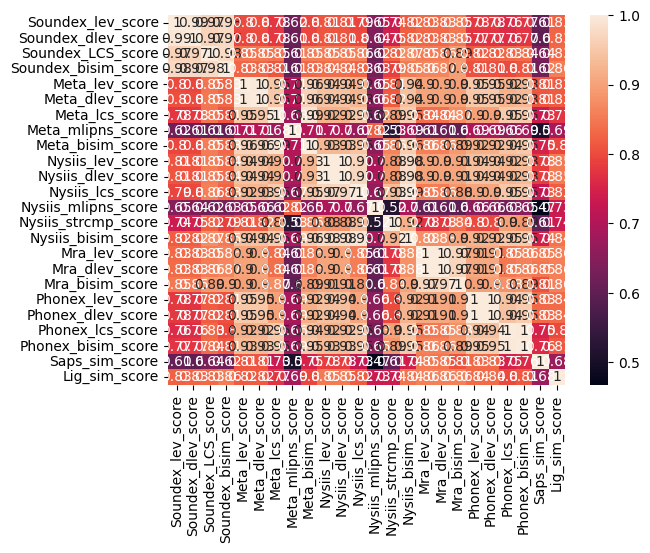

In [36]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.heatmap(df_to_match[['Soundex_lev_score', 'Soundex_dlev_score', 'Soundex_LCS_score', 'Soundex_bisim_score', 'Meta_lev_score', 'Meta_dlev_score', 'Meta_lcs_score', 'Meta_mlipns_score', 'Meta_bisim_score',  'Nysiis_lev_score', 'Nysiis_dlev_score', 'Nysiis_lcs_score', 'Nysiis_mlipns_score', 'Nysiis_strcmp_score', 'Nysiis_bisim_score', 'Mra_lev_score', 'Mra_dlev_score', 'Mra_bisim_score', 'Phonex_lev_score', 'Phonex_dlev_score', 'Phonex_lcs_score', 'Phonex_bisim_score', 'Saps_sim_score', 'Lig_sim_score']].corr(),annot=True)
sns.set(font_scale=2)
sns.set(rc={'figure.figsize':(15,30)})
plt.show()
# soundex lev , dlev , lcs , bisim, -- soundex bisim
# metaphone lev,dlev,lcs, bisim, - -  metaphone bisim
# metaphone lev,dlev,lcs,bisim - nysiis lev , dlev , lcs -- nysiis bisim
# meta mlipins
# nysiis lev, dlev, lcs , bigram  - phonex lev , phonex dlev
# nysiis mlipns
# nysiis strcmp95
# mra lev,dlev,bisim -- mra bisim
# phonex lev, dlev,bisim -- phonex bisim
# saps sim score  
# lig 

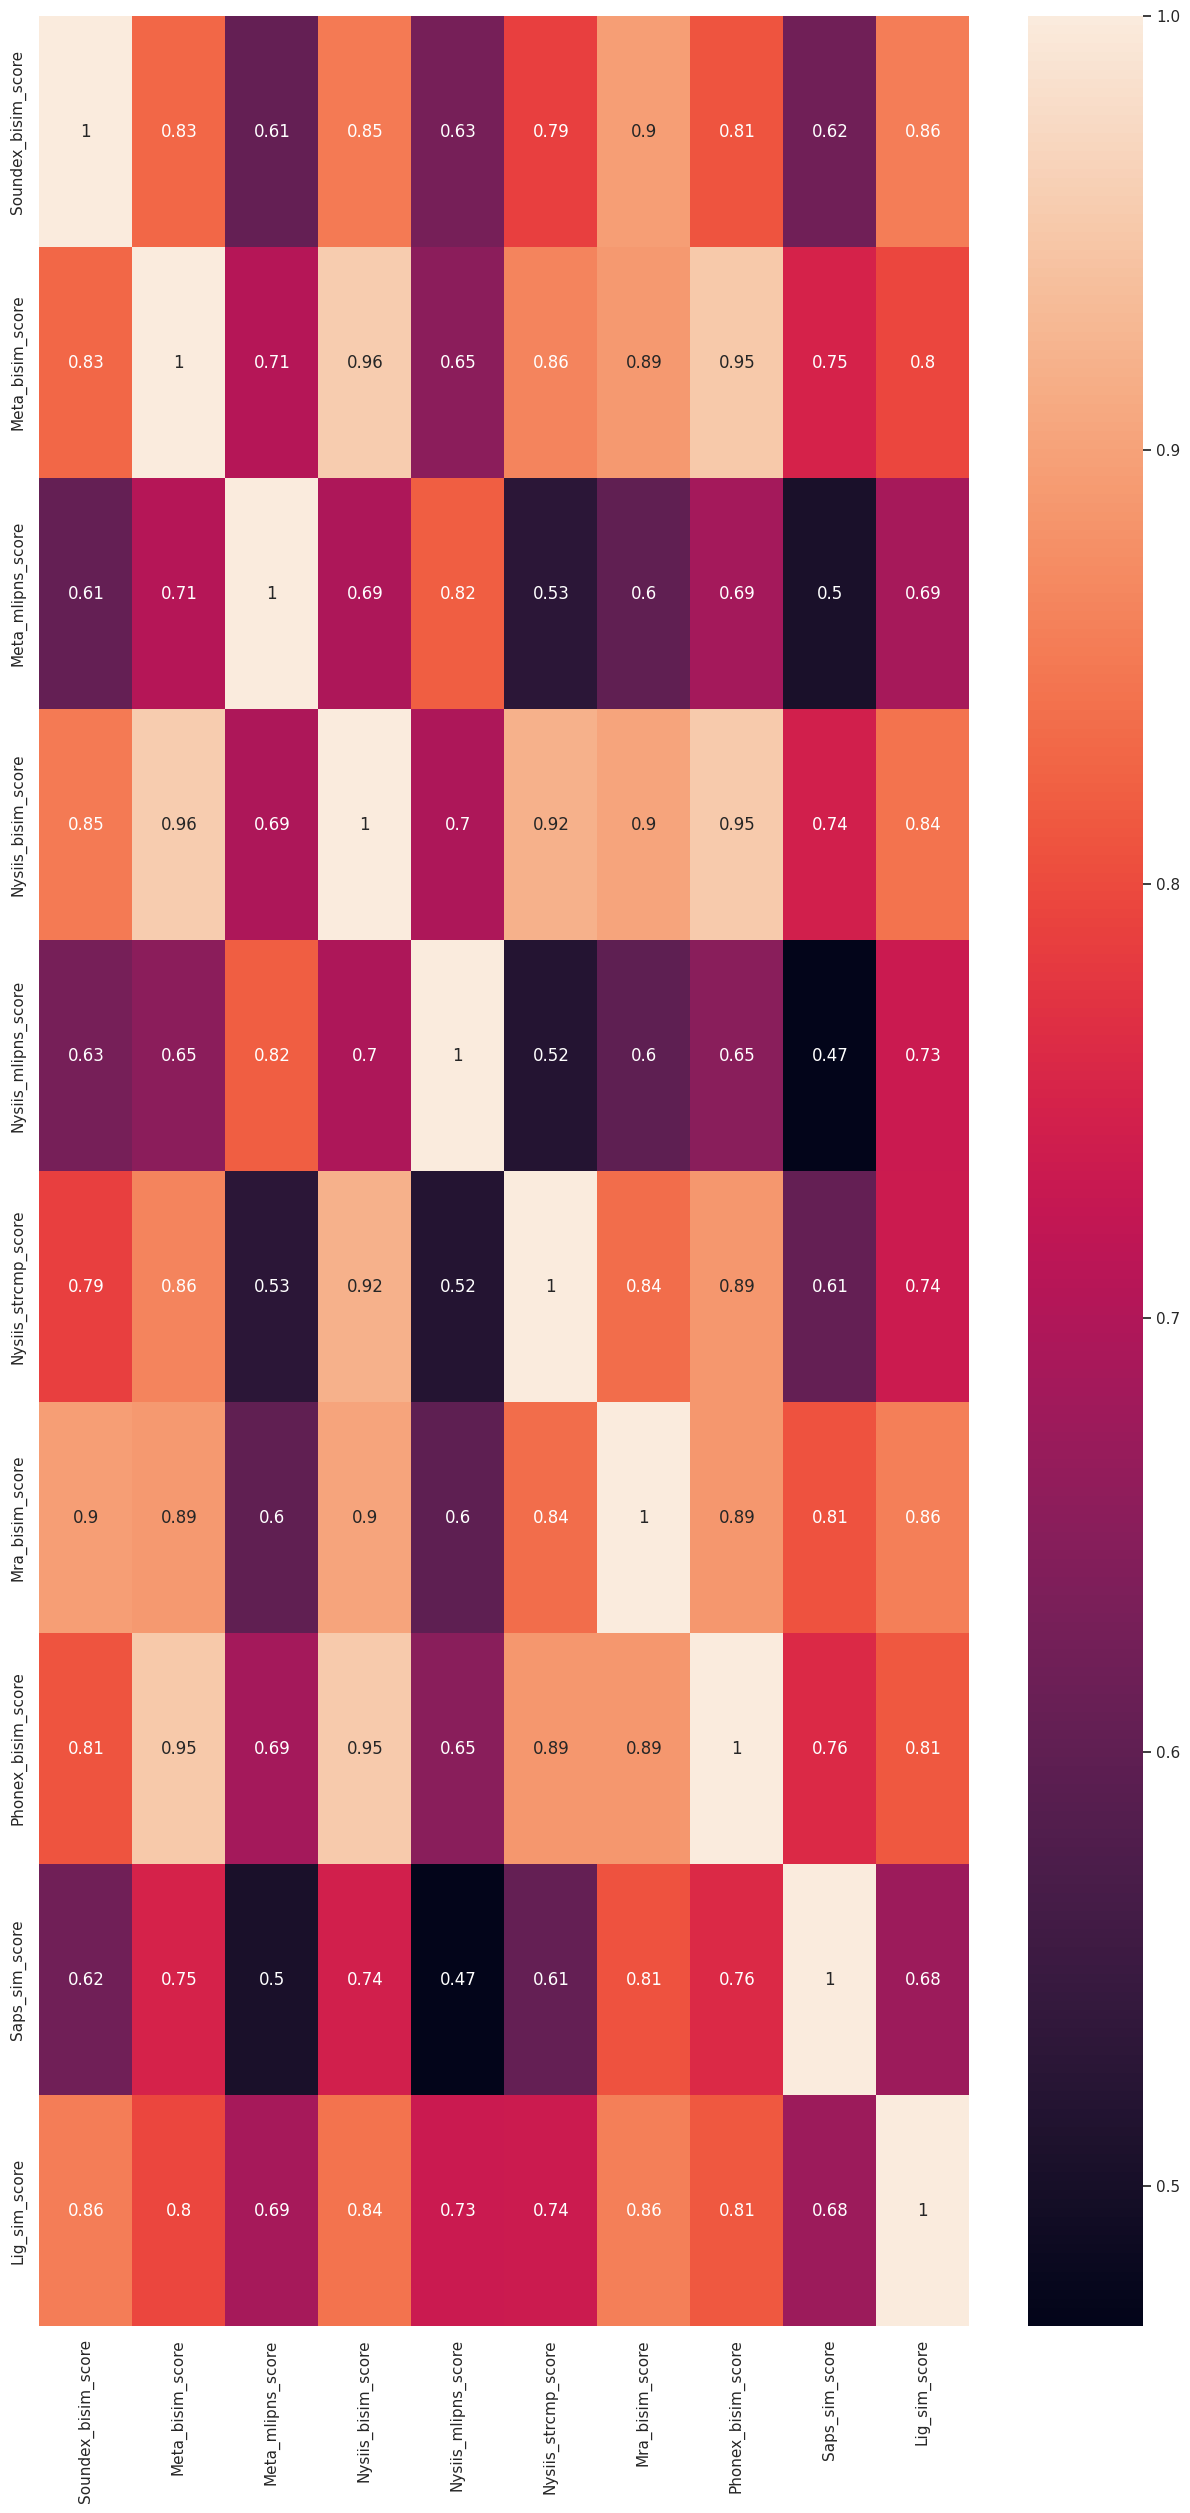

In [37]:
sns.heatmap(df_to_match[['Soundex_bisim_score','Meta_bisim_score','Meta_mlipns_score','Nysiis_bisim_score','Nysiis_mlipns_score', 'Nysiis_strcmp_score','Mra_bisim_score','Phonex_bisim_score','Saps_sim_score', 'Lig_sim_score']].corr(),annot=True)
sns.set(font_scale=0.2)
sns.set(rc={'figure.figsize':(10,10)})
plt.show()

In [38]:
df_to_match.columns

Index(['N_PARTY_WATCHLIST_MATCH_ID', 'ALL_ALIAS_NAMES', 'ALL_PARTY_NAMES', 'ALL_WL_NAMES', 'PARTY_NAMES', 'WL_NAMES', 'NAME_MATCH_SCORE', 'N_MATCH_SCORE', 'PARTY_NAMES_encode', 'WL_NAMES_encode', 'Soundex_lev_score', 'Soundex_dlev_score', 'Soundex_LCS_score', 'Soundex_bisim_score', 'PARTY_NAMES_meta_encode', 'WL_NAMES_meta_encode', 'Meta_lev_score', 'Meta_dlev_score', 'Meta_lcs_score', 'Meta_mlipns_score', 'Meta_bisim_score', 'PARTY_NAMES_nysiis_encode', 'WL_NAMES_nysiis_encode', 'Nysiis_lev_score', 'Nysiis_dlev_score', 'Nysiis_lcs_score', 'Nysiis_mlipns_score', 'Nysiis_strcmp_score', 'Nysiis_bisim_score', 'PARTY_NAMES_mra_encode', 'WL_NAMES_mra_encode', 'Mra_lev_score', 'Mra_dlev_score', 'Mra_bisim_score', 'PARTY_NAMES_pe_encode', 'WL_NAMES_pe_encode', 'Phonex_lev_score', 'Phonex_dlev_score', 'Phonex_lcs_score', 'Phonex_bisim_score', 'Saps_sim_score', 'Lig_sim_score'], dtype='object')

In [0]:
df_to_match2=df_to_match.copy()



In [0]:
# Final selection of fuzzy logics is :'Soundex_bisim_score','Meta_bisim_score','Meta_mlipns_score','Nysiis_bisim_score','Nysiis_mlpins_score', 'Nysiis_strcmp_score','Mra_bisim_score','Phonex_bisim_score','Saps_sim_score', 'Lig_sim_score'
# total 10 fuzzy logics selected
for i in ['Soundex_bisim_score','Meta_bisim_score','Meta_mlipns_score','Nysiis_bisim_score','Nysiis_mlipns_score', 'Nysiis_strcmp_score','Mra_bisim_score','Phonex_bisim_score','Saps_sim_score', 'Lig_sim_score']:
    df_to_match["Final_"+i]=df_to_match[i].values



In [0]:
df_to_match=df_to_match[['N_PARTY_WATCHLIST_MATCH_ID','ALL_ALIAS_NAMES', 'ALL_PARTY_NAMES', 'ALL_WL_NAMES',"PARTY_NAMES","WL_NAMES","SIAMESE_MATCH_SCORE","N_MATCH_SCORE",'Final_Soundex_bisim_score', 'Final_Meta_mlipns_score', 'Final_Meta_bisim_score', 'Final_Nysiis_mlipns_score', 'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Saps_sim_score', 'Final_Lig_sim_score', 'Final_Mra_bisim_score']]
df_to_match[['Final_Soundex_bisim_score', 'Final_Meta_mlipns_score', 'Final_Meta_bisim_score', 'Final_Nysiis_mlipns_score', 'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Saps_sim_score', 'Final_Lig_sim_score', 'Final_Mra_bisim_score']]

# Data Integration

In [0]:
df=pd.merge(df,df_to_match,how='left',on="N_PARTY_WATCHLIST_MATCH_ID")

In [0]:
df["V_RESOLUTION"]=df["V_RESOLUTION"].apply(lambda x: 1 if x in ["TH","THNM"] else 0)
df.shape

In [0]:
df.columns

In [45]:
df.columns[df.columns.str.contains("DOB")]

Index(['V_CUST_DOB', 'V_DOB', 'V_DOB_2', 'V_WATCHLIST_DOB_2', 'V_IC_DOB', 'FINAL_DOB_MATCH', 'DOB_MATCH_1', 'DOB_MATCH_2', 'DOB_MATCH_3', 'DOB_MATCH_4'], dtype='object')

# Data Visualization

In [49]:
df[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE",'Final_Soundex_bisim_score', 'Final_Meta_mlipns_score', 'Final_Meta_bisim_score', 'Final_Nysiis_mlipns_score', 'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Saps_sim_score', 'Final_Lig_sim_score', 'Final_Mra_bisim_score',"V_RESOLUTION"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 701181 entries, 0 to 701180
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   FINAL_DOB_MATCH            701181 non-null  float64
 1   ID_score                   701181 non-null  float64
 2   NAME_MATCH_SCORE           701181 non-null  float64
 3   N_MATCH_SCORE              701181 non-null  float64
 4   Final_Soundex_bisim_score  701181 non-null  float64
 5   Final_Meta_mlipns_score    701181 non-null  float64
 6   Final_Meta_bisim_score     701181 non-null  float64
 7   Final_Nysiis_mlipns_score  701181 non-null  float64
 8   Final_Nysiis_strcmp_score  701181 non-null  float64
 9   Final_Nysiis_bisim_score   701181 non-null  float64
 10  Final_Phonex_bisim_score   701181 non-null  float64
 11  Final_Saps_sim_score       701181 non-null  float64
 12  Final_Lig_sim_score        701181 non-null  float64
 13  Final_Mra_bisim_score      70

In [50]:
df[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE",'Final_Soundex_bisim_score', 'Final_Meta_mlipns_score', 'Final_Meta_bisim_score', 'Final_Nysiis_mlipns_score', 'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Saps_sim_score', 'Final_Lig_sim_score', 'Final_Mra_bisim_score',"V_RESOLUTION"]].describe()
# mean values for FINAL_DOB_MATCH, ID_score is negative which means that count of -1 values is higher than all non-negative values.Further since -1 data points are high std deviations for them is also high.


FINAL_DOB_MATCH       ID_score  NAME_MATCH_SCORE  N_MATCH_SCORE  Final_Soundex_bisim_score  Final_Meta_mlipns_score  Final_Meta_bisim_score  Final_Nysiis_mlipns_score  Final_Nysiis_strcmp_score  Final_Nysiis_bisim_score  Final_Phonex_bisim_score  Final_Saps_sim_score  Final_Lig_sim_score  Final_Mra_bisim_score   V_RESOLUTION
count    701181.000000  701181.000000      7.011810e+05  701181.000000              701181.000000            701181.000000           701181.000000              701181.000000              701181.000000             701181.000000             701181.000000         701181.000000        701181.000000          701181.000000  701181.000000
mean         -0.038038      -0.303257      2.791814e-01      95.471430                   0.760267                 0.589060                0.776555                   0.537526                   0.880495                  0.802795                  0.783540              0.699638             0.713855               0.783186       0.156186
std           0.715968       0.695746      4.800526e-01       4.015393                   0.313086                 0.492005                0.259166                   0.498590                   0.210841                  0.246587                  0.246714              0.426352             0.357762               0.284643       0.363032
min          -1.000000      -1.000000     -1.000000e+00      90.000000                   0.000000                 0.000000                0.000000                   0.000000                   0.000000                  0.000000                  0.000000              0.000000             0.000000               0.000000       0.000000
25%          -1.000000      -1.000000      1.243681e-10      92.000000                   0.625000                 0.000000                0.650000                   0.000000                   0.847811                  0.690476                  0.660000              0.214286             0.454545               0.666667       0.000000
50%           0.000000       0.000000      7.229390e-04      94.000000                   1.000000                 1.000000                0.833333                   1.000000                   0.955556                  0.888889                  0.863636              1.000000             0.937500               1.000000       0.000000
75%           0.600000       0.000000      8.797652e-01     100.000000                   1.000000                 1.000000                1.000000                   1.000000                   1.000000                  1.000000                  1.000000              1.000000             1.000000               1.000000       0.000000
max           1.000000       1.000000      8.855559e-01     100.000000                   1.000000                 1.000000                1.000000                   1.000000                   1.000000                  1.000000                  1.000000              1.000000             1.000000               1.000000       1.000000

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
sns.__version__

'0.13.0'

<Axes: >

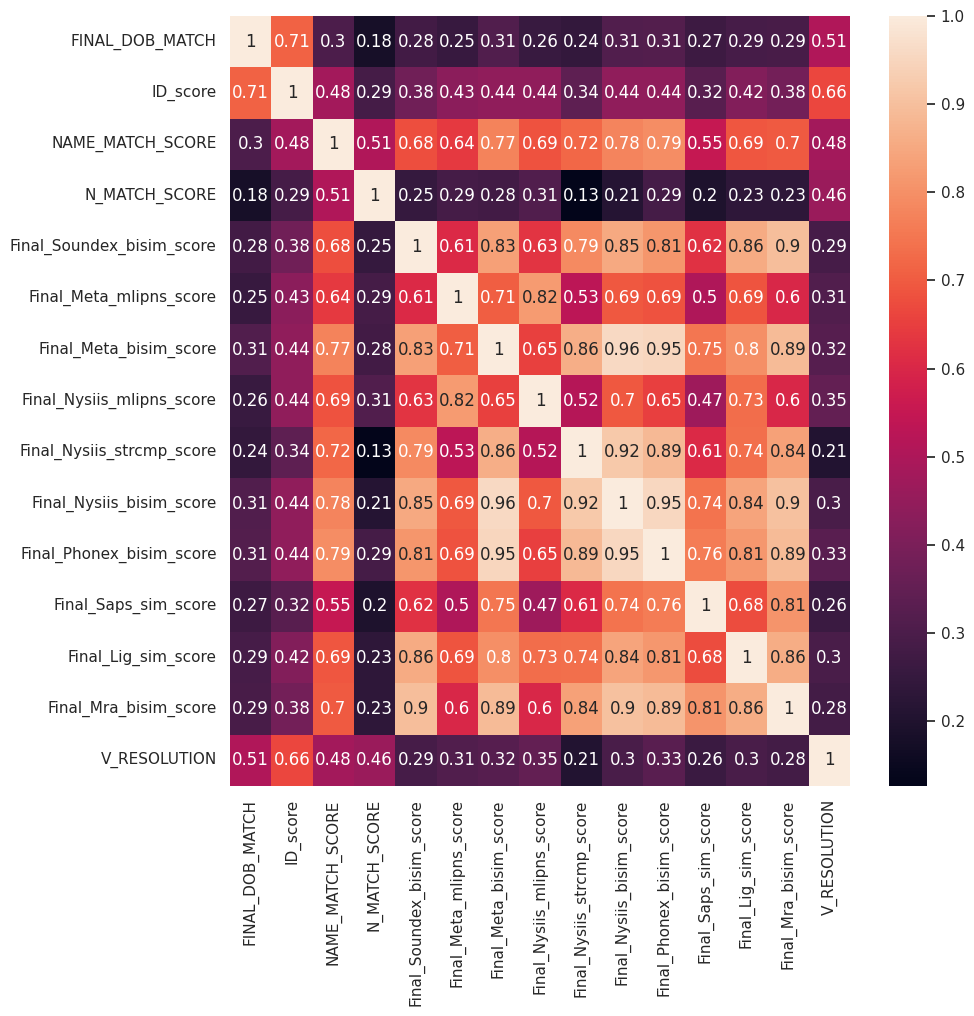

In [53]:
sns.heatmap(df[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE",'Final_Soundex_bisim_score', 'Final_Meta_mlipns_score', 'Final_Meta_bisim_score', 'Final_Nysiis_mlipns_score', 'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Saps_sim_score', 'Final_Lig_sim_score', 'Final_Mra_bisim_score',"V_RESOLUTION"]].corr(),annot=True)

In [54]:
df["V_RESOLUTION"]

0         0
1         1
2         1
3         0
4         0
         ..
701176    0
701177    0
701178    0
701179    0
701180    0
Name: V_RESOLUTION, Length: 701181, dtype: int64

In [55]:
df.columns

Index(['V_UCIF_ID', 'N_WATCHLIST_PROFILE_ID', 'N_PARTY_WATCHLIST_MATCH_ID', 'D_CREATED_DTM', 'V_CUST_DOB', 'V_DOB', 'V_DOB_2', 'V_WATCHLIST_DOB_2', 'V_IC_DOB', 'V_COMMENTS', 'V_RESOLUTION', 'FINAL_DOB_MATCH', 'DOB_MATCH_1', 'DOB_MATCH_2', 'DOB_MATCH_3', 'DOB_MATCH_4', 'ID_score', 'al_wl_ids', 'cust_id_all_sp_accom', 'trans_agg_v_id_type', 'score1', 'ALL_ALIAS_NAMES', 'ALL_PARTY_NAMES', 'ALL_WL_NAMES', 'PARTY_NAMES', 'WL_NAMES', 'NAME_MATCH_SCORE', 'N_MATCH_SCORE', 'Final_Soundex_bisim_score', 'Final_Meta_mlipns_score', 'Final_Meta_bisim_score', 'Final_Nysiis_mlipns_score', 'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Saps_sim_score', 'Final_Lig_sim_score', 'Final_Mra_bisim_score'], dtype='object')

Pairplot

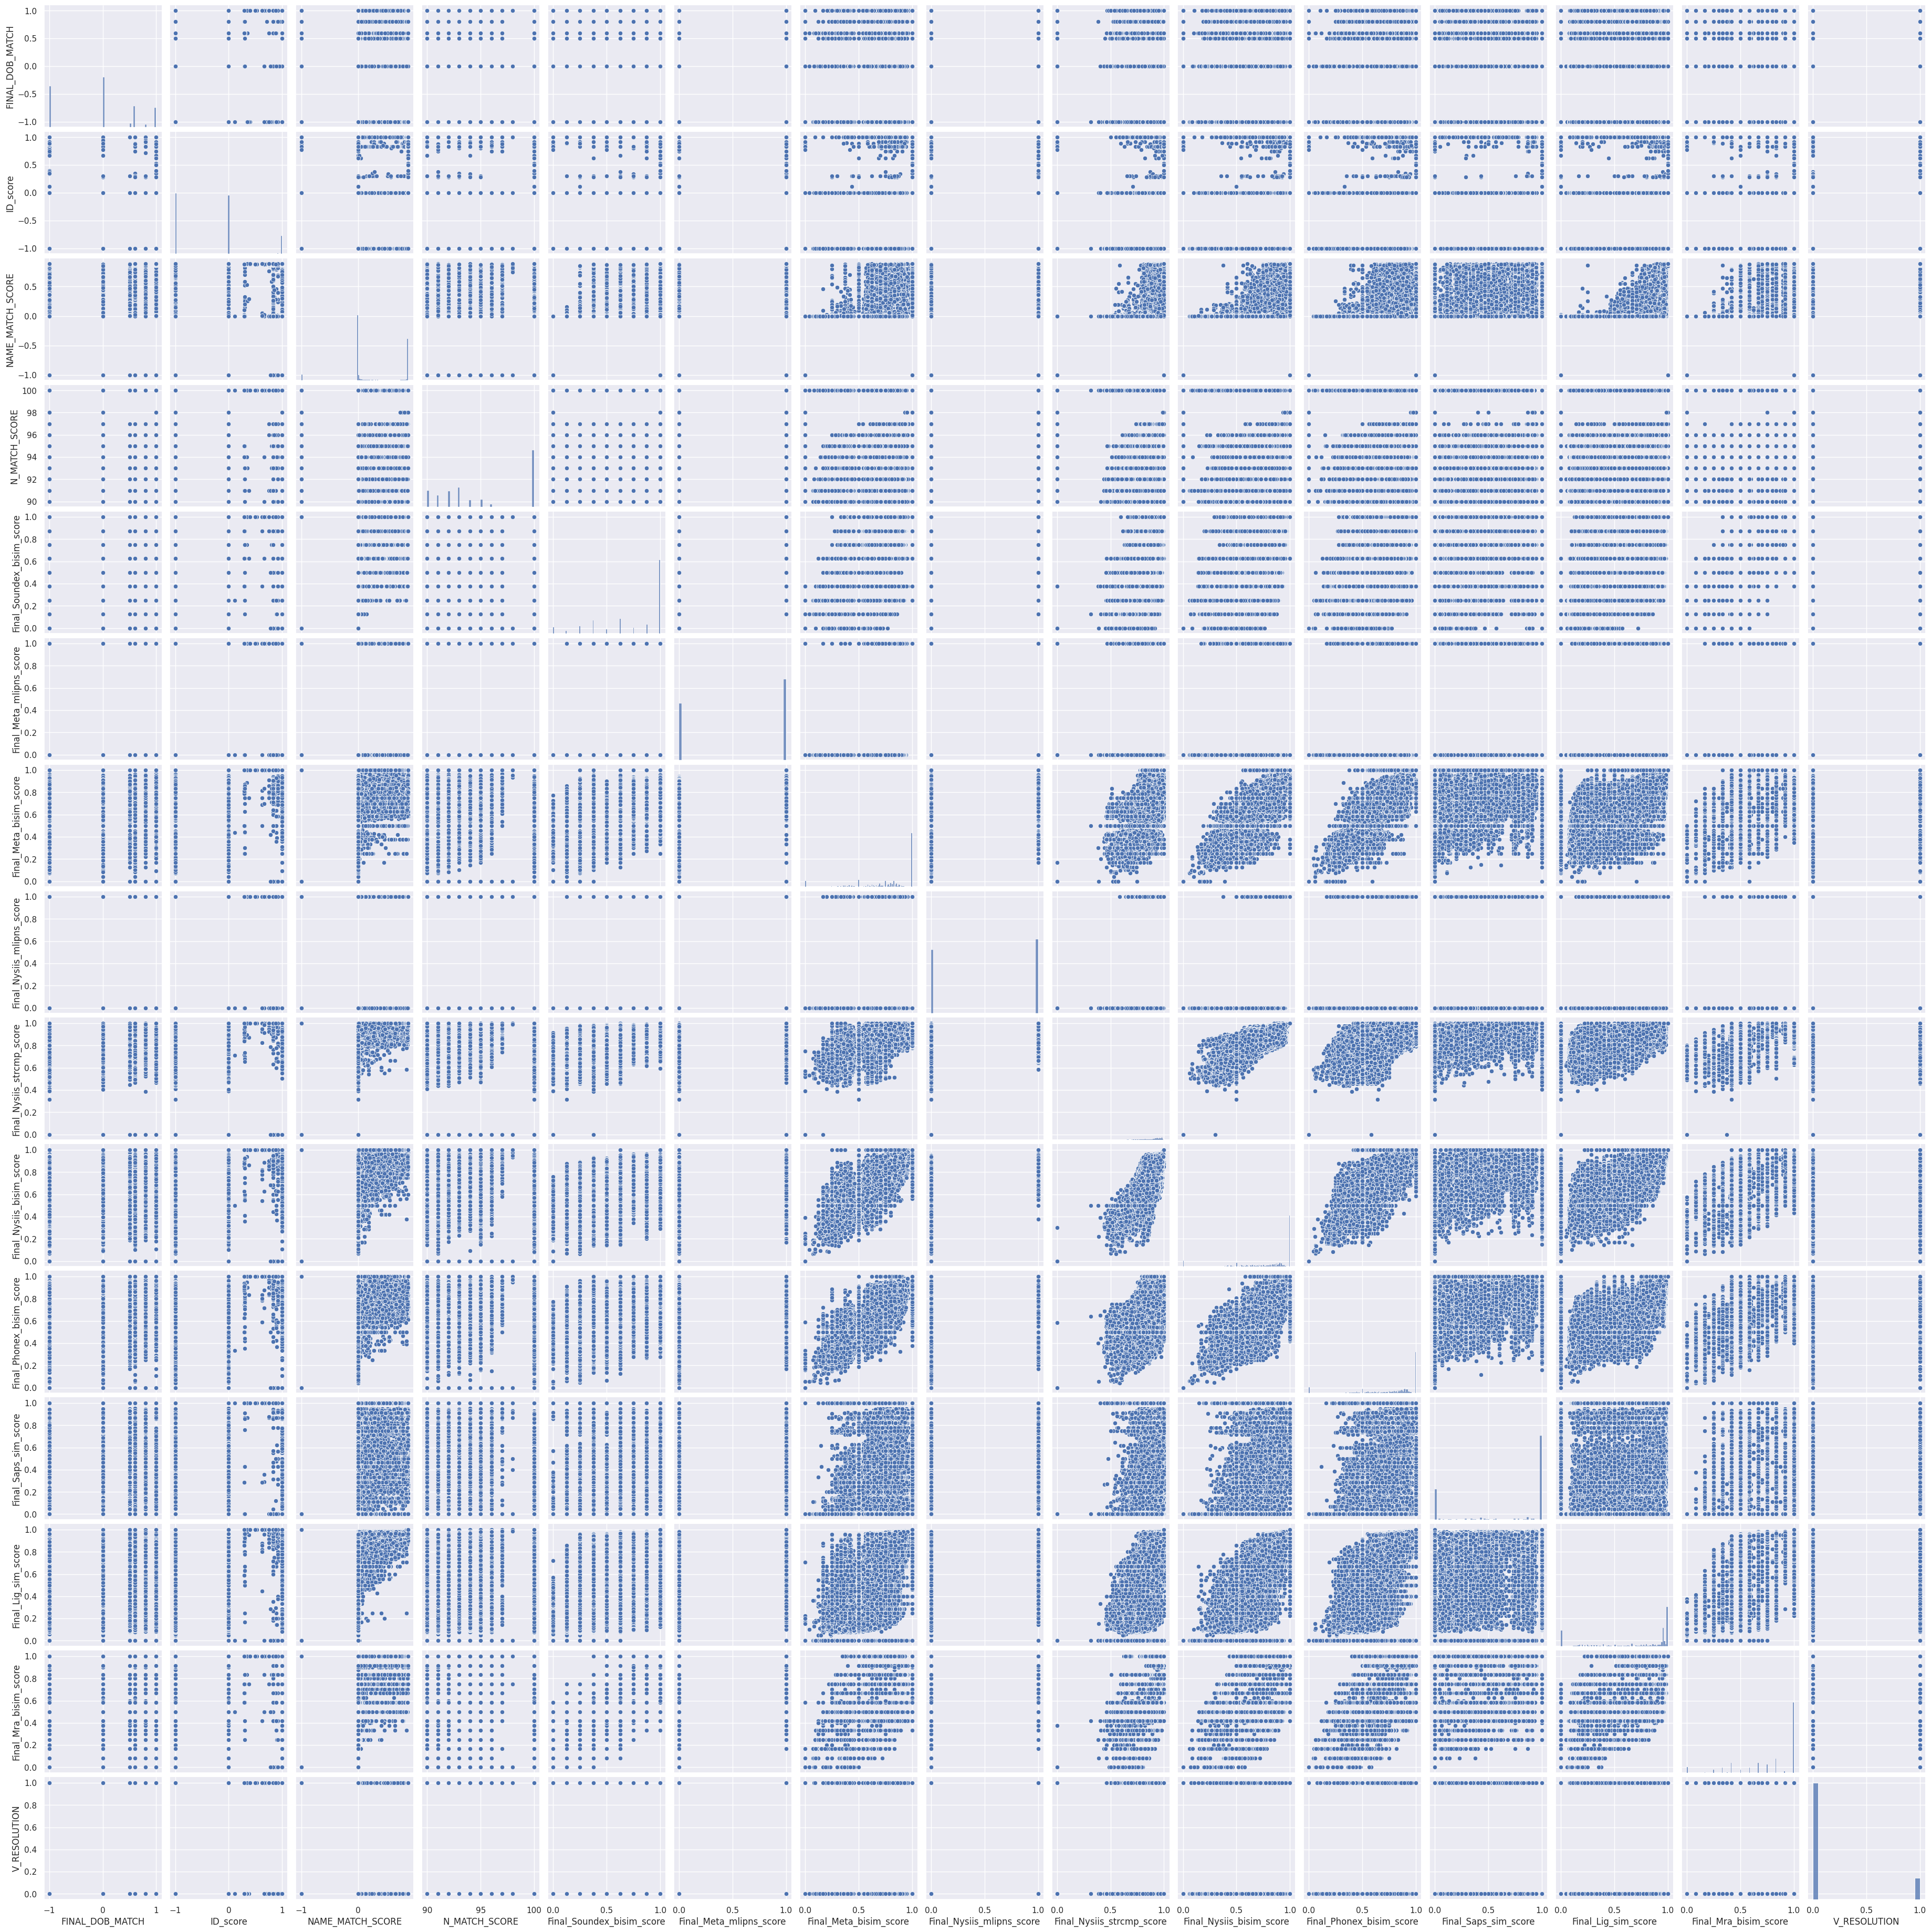

In [56]:
sns.pairplot(df[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE",'Final_Soundex_bisim_score', 'Final_Meta_mlipns_score', 'Final_Meta_bisim_score', 'Final_Nysiis_mlipns_score', 'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Saps_sim_score', 'Final_Lig_sim_score', 'Final_Mra_bisim_score',"V_RESOLUTION"]],kind="scatter")
# the plots are all linear in nature 

In [57]:
# histograpm for each similarity scores
# box plot for each histogram
# bar plot
# regplot
# pairplot
# 

Displot

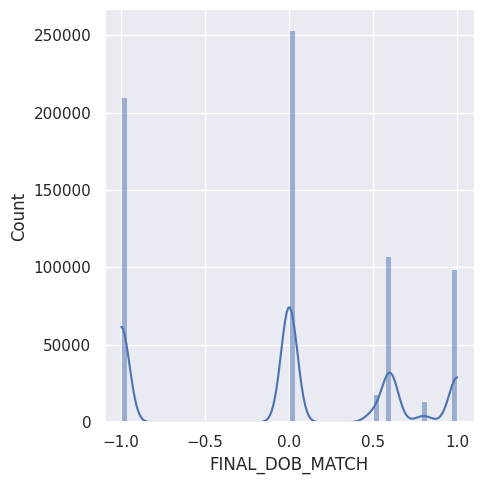

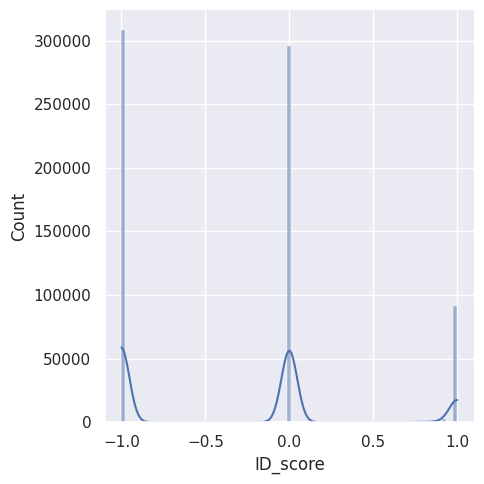

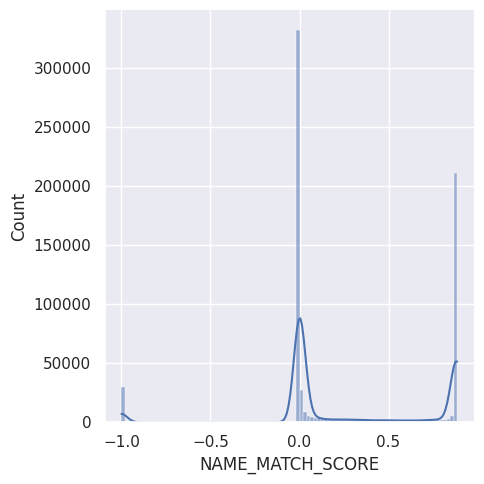

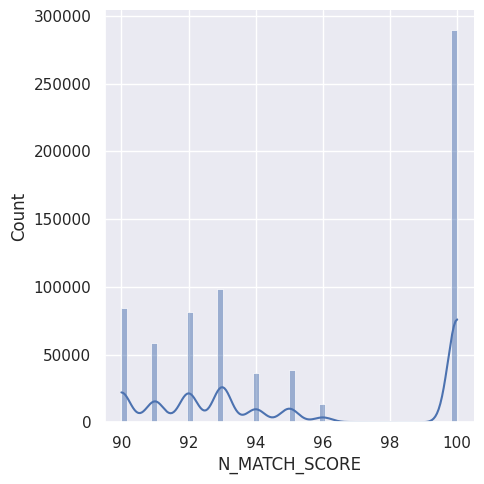

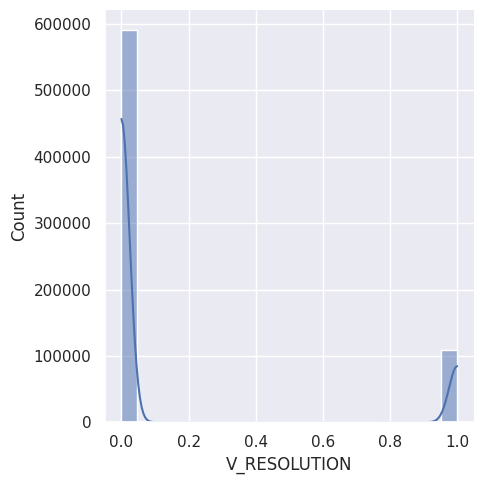

In [58]:
sns.displot(df["FINAL_DOB_MATCH"],kde=True) # most values taken are 0 (approx 2.5lac) followed by -1(2lac) and then  0.6,1 (1lac each) and 0.5 & 0.75 
sns.displot(df["ID_score"],kde=True)          #  almost -1 & 0 have  are from 3 lac alerts each and 1 lac alerts with 1 value.
sns.displot(df["SIAMESE_MATCH_SCORE"],kde=True)  #  name score has varying value b/w 0 to 1 with peak coming at at values close to 0 and fall at 0.5. 
sns.displot(df["N_MATCH_SCORE"],kde=True)     #  takes highest value at score 100.
sns.displot(df["V_RESOLUTION"],kde=True)      
                                
# the range of values 

Joinplot for every variable because - all variables are numerical

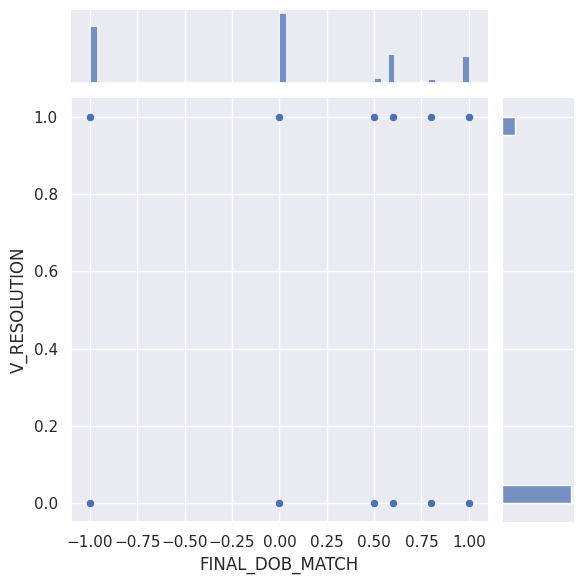

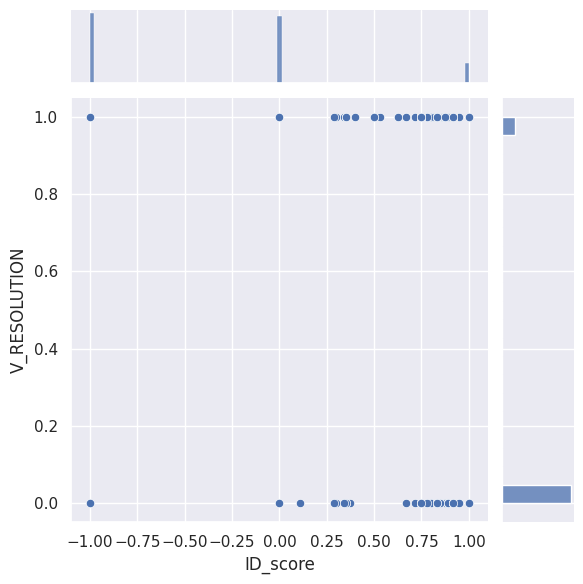

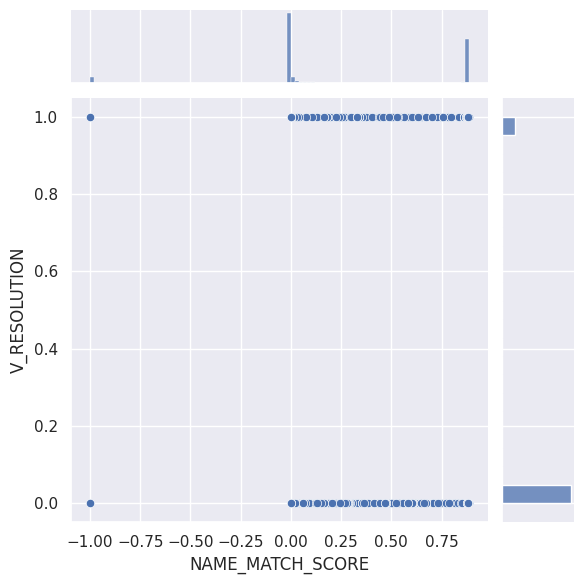

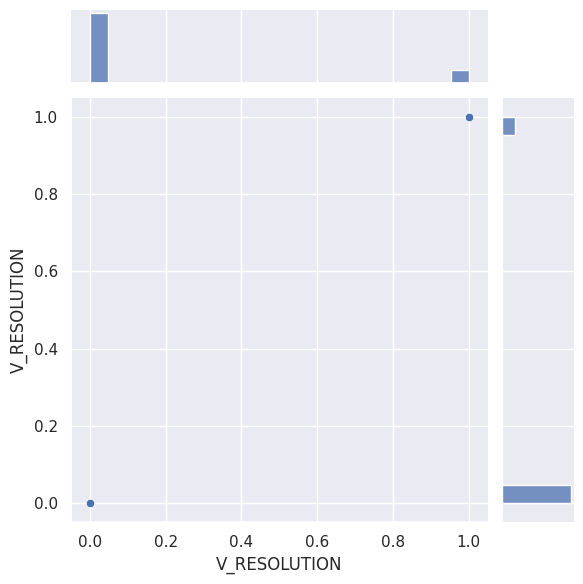

In [59]:
sns.jointplot(x="FINAL_DOB_MATCH",y="V_RESOLUTION",data=df)
sns.jointplot(x="ID_score",y="V_RESOLUTION",data=df)
sns.jointplot(x="SIAMESE_MATCH_SCORE",y="V_RESOLUTION",data=df)
sns.jointplot(x="V_RESOLUTION",y="V_RESOLUTION",data=df)


Boxplot -only for continuous variables not for discrete variables- SIAMESE_MATCH_SCORE,ID_score and gives whether info on median, 1st & 3rd quartile and variation of values

<Axes: ylabel='ID_score'>

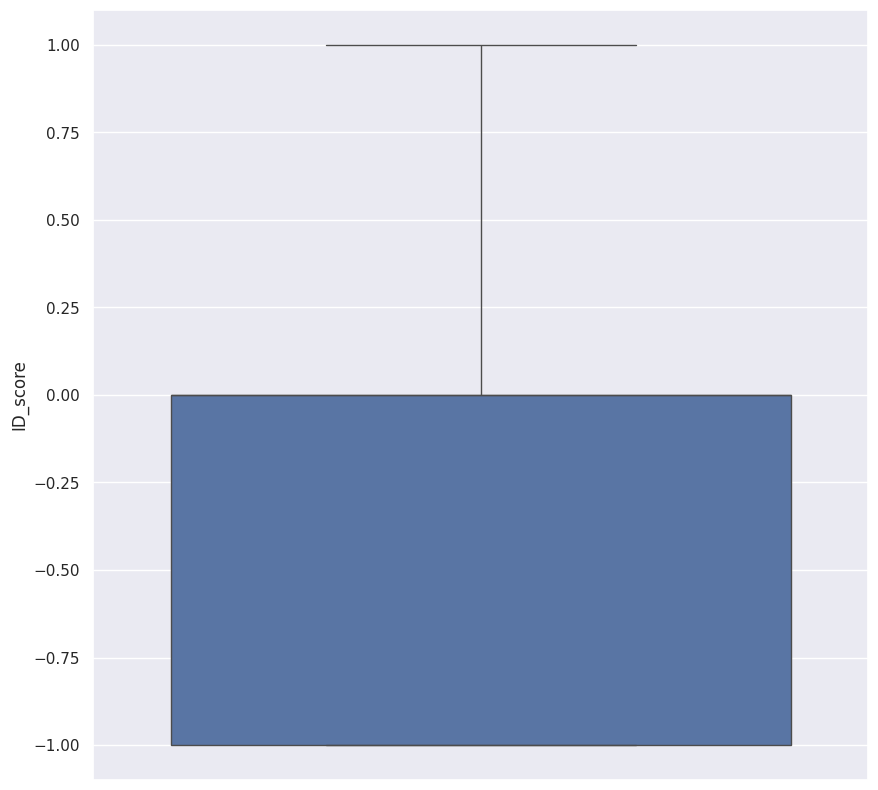

In [60]:
sns.boxplot(df["ID_score"])
# ID has median and 3rd quartile overlapping at 0.So 50% of values are <=0. No outliers

<Axes: ylabel='NAME_MATCH_SCORE'>

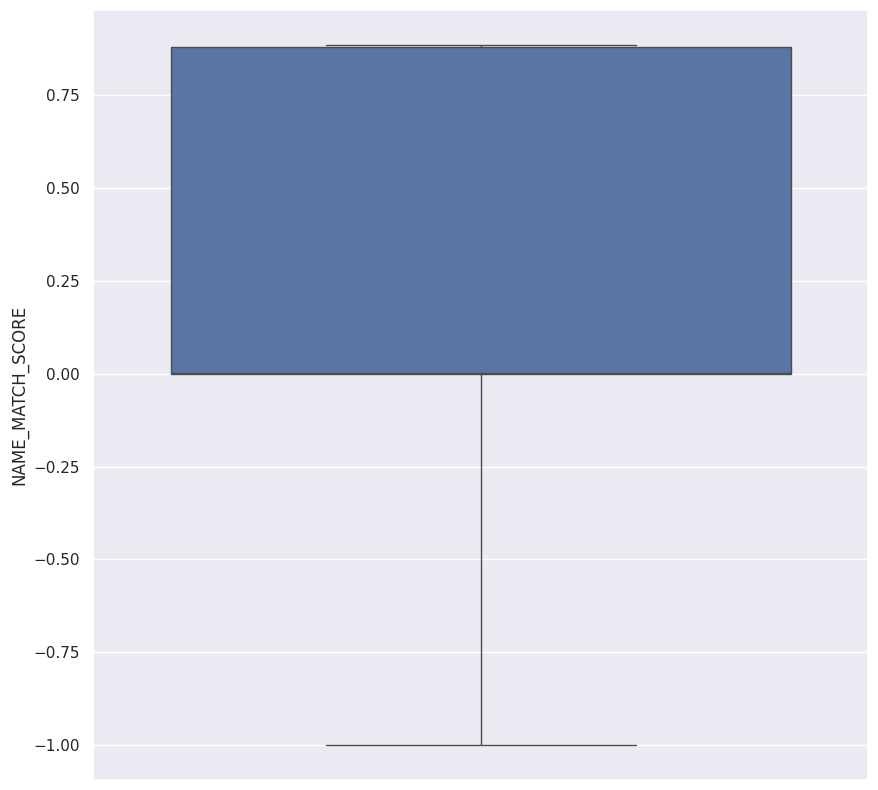

In [61]:
sns.boxplot(df["SIAMESE_MATCH_SCORE"]) # median lies close to 1st quartile that means that majority of values have lower values i.e 0.1.

Barplot -gives an estimation of central tendency of each feature against match & miss-match

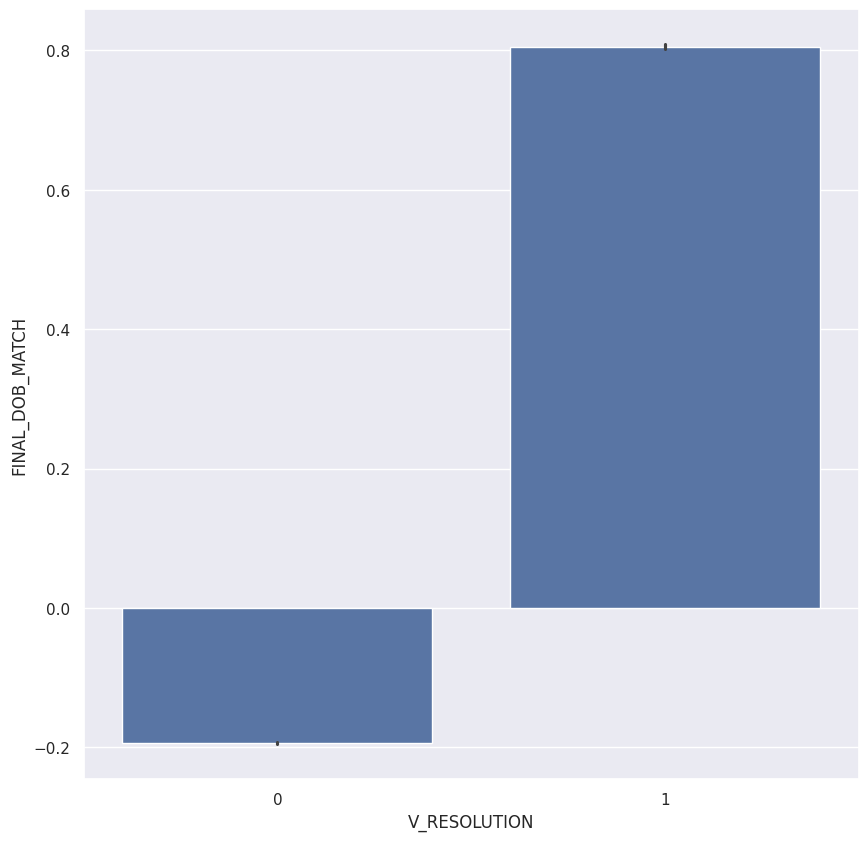

In [62]:
sns.barplot(x="V_RESOLUTION",y="FINAL_DOB_MATCH",data=df,errorbar=('ci', 95))
plt.show()

<Axes: xlabel='V_RESOLUTION', ylabel='ID_score'>

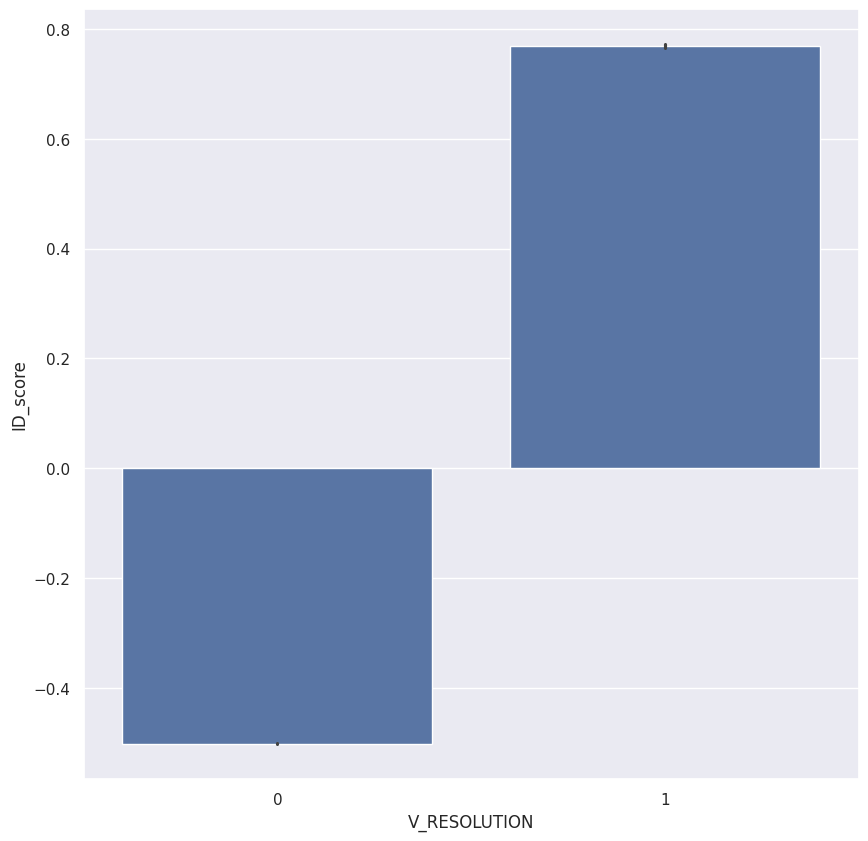

In [63]:
sns.barplot(x="V_RESOLUTION",y="ID_score",data=df,errorbar=('ci', 95))

<Axes: xlabel='V_RESOLUTION', ylabel='NAME_MATCH_SCORE'>

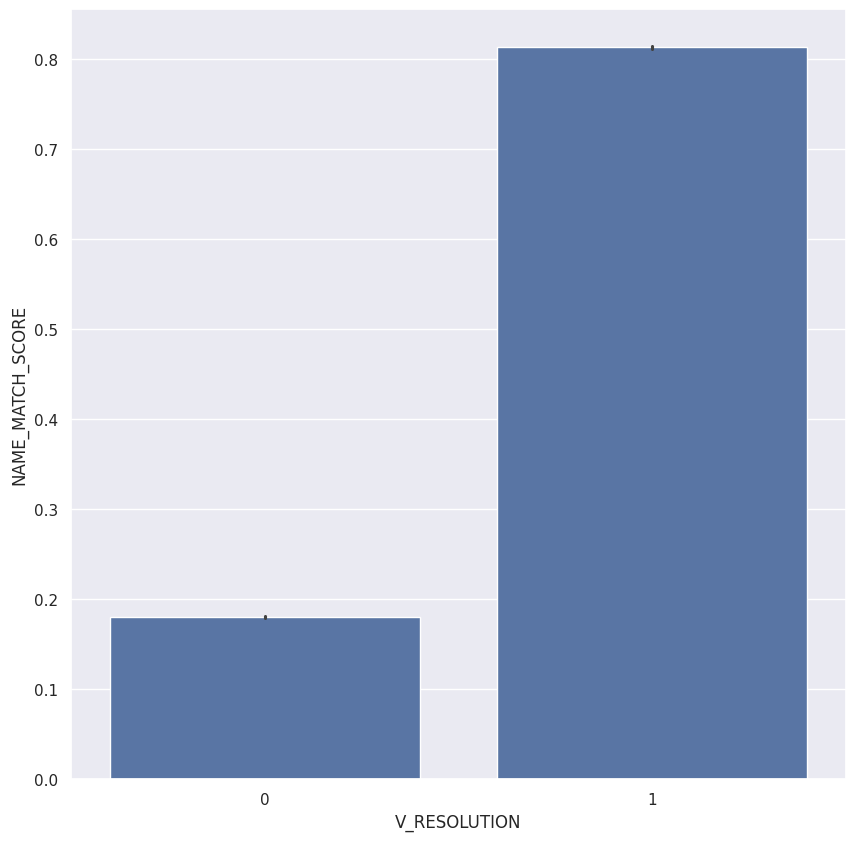

In [64]:
sns.barplot(x="V_RESOLUTION",y="SIAMESE_MATCH_SCORE",data=df,errorbar=('ci', 95))

In [65]:
sns.__version__

'0.13.0'

# Model Development

In [0]:
df_train=df.copy()
print("shape of train dataset",df_train.shape)

In [0]:
df

In [0]:
# the alerts counts for which data is absent in customer/watchlist side but resolution is there
df_train[df_train["FINAL_DOB_MATCH"]==-1]["V_RESOLUTION"].value_counts()

In [0]:
df_train["V_RESOLUTION"].unique()

In [0]:
val_counts=df_train["V_RESOLUTION"].value_counts()
df_train["V_RESOLUTION"].value_counts()

### Check for imbalance

In [0]:
print("counts of alerts with resolution 0 in train %",df_train["V_RESOLUTION"].value_counts().loc[0]/df_train["V_RESOLUTION"].shape[0])
print("counts of alerts with resolution 1 in train %",df_train["V_RESOLUTION"].value_counts().loc[1]/df_train["V_RESOLUTION"].shape[0])

 So this is moderately imbalanced , hence no need of doing anything against this imbalancing

### Train-test split

In [60]:
from sklearn.model_selection import train_test_split
df_train=df_train.rename(columns={"NAME_MATCH_SCORE":"SIAMESE_MATCH_SCORE"})
X_train=df_train[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE",'Final_Soundex_bisim_score', 'Final_Meta_mlipns_score', 'Final_Meta_bisim_score', 'Final_Nysiis_mlipns_score', 'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Saps_sim_score', 'Final_Lig_sim_score', 'Final_Mra_bisim_score']]
y_train=df_train["V_RESOLUTION"]

In [0]:
train_dataset_path=os.path.join(folder_path,"Final_training_dataset.csv")
df_train.to_csv(train_dataset_path)

In [59]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
train_dataset_path=os.path.join(folder_path,"Final_training_dataset.csv")
df_train=pd.read_csv(train_dataset_path)

In [49]:
X_unseen=df_test[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE",'Final_Soundex_bisim_score', 'Final_Meta_mlipns_score', 'Final_Meta_bisim_score', 'Final_Nysiis_mlipns_score', 'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Saps_sim_score', 'Final_Lig_sim_score', 'Final_Mra_bisim_score']]
y_unseen=df_test["V_RESOLUTION"]

In [50]:
df_test["V_RESOLUTION"].value_counts()

0    8410
1    1052
Name: V_RESOLUTION, dtype: int64

### Classification model

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm
import catboost
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,f1_score,classification_report,precision_score,recall_score,roc_curve,roc_auc_score

Overall the metric to be checked is f-1 score for target value 1 becoz we need to keep good accuracy on both resolutions.But specifically to analyze how many fp have been reduced we need to see
the precision for target variable 1 (maximizing precision for target var 1 is equivalent to maximzing recall for target value 0).


In [77]:
'''
classifier_SVM = SVC(kernel='rbf',random_state=0)
classifier_SVM.fit(X_train,y_train)
y_predict_train=classifier_SVM.predict(X_train)
y_predict=classifier_SVM.predict(X_test)
y_predict_2=classifier_SVM.predict(X_test_2)
print("results from SVM model, Train data ")
print(classification_report(y_train,y_predict_train))
print("results from SVM model,  Test data")
print(classification_report(y_test,y_predict))
print("results from SVM model, Unseen data")
print(classification_report(y_test_2,y_predict_2))
score=cross_val_score(classifier_SVM,X_train,y_train,cv=5,scoring='f1_macro')
print("cross_val_f1_score meand & std. deviation",score.mean(),score.std())
results["SVM"]=f1_score(y_test_2,y_predict_2)
'''

'\nclassifier_SVM = SVC(kernel=\'rbf\',random_state=0)\nclassifier_SVM.fit(X_train,y_train)\ny_predict_train=classifier_SVM.predict(X_train)\ny_predict=classifier_SVM.predict(X_test)\ny_predict_2=classifier_SVM.predict(X_test_2)\nprint("results from SVM model, Train data ")\nprint(classification_report(y_train,y_predict_train))\nprint("results from SVM model,  Test data")\nprint(classification_report(y_test,y_predict))\nprint("results from SVM model, Unseen data")\nprint(classification_report(y_test_2,y_predict_2))\nscore=cross_val_score(classifier_SVM,X_train,y_train,cv=5,scoring=\'f1_macro\')\nprint("cross_val_f1_score meand & std. deviation",score.mean(),score.std())\nresults["SVM"]=f1_score(y_test_2,y_predict_2)\n'

### Model function

In [57]:
results={}


for model_name in ["LG","Random forest","LightGBM","XG Boost"]:
    if model_name=="LG":
        classifier_lg=LogisticRegression(class_weight="balanced",random_state=0)
        classifier_lg.fit(X_train,y_train)
        y_predict_train=classifier_lg.predict(X_train)
       # y_predict=classifier_lg.predict(X_test)
        y_predict_2=classifier_lg.predict(X_unseen)
        print("results from Logistic Regression model on train data")
        print(classification_report(y_train,y_predict_train))
       # print("results from Logistic Regression model on test data")
       # print(classification_report(y_train,y_predict_train))
        print("results from Logistic Regression model on Unseen data")
        print(classification_report(y_unseen,y_predict_2))
     #   score=cross_val_score(classifier_lg,X_train,y_train,cv=5,scoring='f1')
     #   print("cross_val_f1_score meand & std. deviation",score.mean(),score.std())
     #   results["LG"]=f1_score(y_unseen,y_predict_2)   
    if model_name=="LightGBM":
        classifier_lgbm=LGBMClassifier(random_state=1,verbose_eval=False)
        classifier_lgbm.fit(X_train,y_train)
        y_predict_train=classifier_lgbm.predict(X_train)
       # y_predict=classifier_lgbm.predict(X_test)
        y_predict_2=classifier_lgbm.predict(X_unseen)
        print("results from LightGBM model, Train data ")
        print(classification_report(y_train,y_predict_train))
    #    print("results from LightGBM model,  Test data")
    #    print(classification_report(y_test,y_predict))
        print("results from LightGBM model, Unseen data")
        print(classification_report(y_unseen,y_predict_2))
   #      score=cross_val_score(classifier_lgbm,X_train,y_train,cv=5,scoring='f1')
   #     print("cross_val_f1_score meand & std. deviation",score.mean(),score.std())
   #     results["LightGBM"]=f1_score(y_unseen,y_predict_2)        
    elif model_name =="Random forest":
        # Random forest 

        classifier_RF=RandomForestClassifier(max_features=None,random_state=0)
        classifier_RF.fit(X_train, y_train)
        y_predict_train=classifier_RF.predict(X_train)
        #y_predict=classifier_RF.predict(X_test)
        y_predict_2=classifier_RF.predict(X_unseen)
        print("results from RF model, Train data ")
        print(classification_report(y_train,y_predict_train))
   #     print("results from RF model,  Test data")
   #     print(classification_report(y_test,y_predict))
        print("results from RF model, Unseen data")
        print(classification_report(y_unseen,y_predict_2))
   #     score=cross_val_score(classifier_RF,X_train,y_train,cv=5,scoring='f1_macro')
   #     print("cross_val_f1_score meand & std. deviation",score.mean(),score.std())
   #     results["RF"]=f1_score(y_unseen,y_predict_2)
       
    # XGBoost
    elif model_name=="XG Boost":
        classifier_XGB = xgb.XGBClassifier(random_state=0)
        classifier_XGB.fit(X_train, y_train)
        y_predict_train=classifier_XGB.predict(X_train)
        #y_predict=classifier_XGB.predict(X_test)
        y_predict_2=classifier_XGB.predict(X_unseen)
        print("Results from XGBoost model, Train data ")
        print(classification_report(y_train,y_predict_train))
  #      print("results from XG Boost model,  Test data")
  #      print(classification_report(y_test,y_predict))
        print("results from XG Boost model, Unseen data")
        print(classification_report(y_unseen,y_predict_2))
  #     score=cross_val_score(classifier_XGB,X_train,y_train,cv=5,scoring='f1')
  #      print("cross_val_f1_score meand & std. deviation",score.mean(),score.std())        
  #      results["XGBoost"]=f1_score(y_unseen,y_predict_2)
        



results from Logistic Regression model on train data
              precision    recall  f1-score   support

           0       0.98      0.89      0.93    591666
           1       0.60      0.89      0.72    109515

    accuracy                           0.89    701181
   macro avg       0.79      0.89      0.82    701181
weighted avg       0.92      0.89      0.90    701181

results from Logistic Regression model on Unseen data
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      8410
           1       0.32      0.60      0.41      1052

    accuracy                           0.81      9462
   macro avg       0.63      0.72      0.65      9462
weighted avg       0.87      0.81      0.83      9462

results from RF model, Train data 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    591666
           1       0.99      0.94      0.96    109515

    accuracy                           0

In [0]:
X_train

In [0]:
'''
# LightGBM
predicted_proba=classifier_lgbm.predict_proba(X_train)
FPR, TPR, proba = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["LightGBM"]=optimal_proba_cutoff
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in classifier_lgbm.predict_proba(X_test)[:, -1]]
print(classification_report(y_test,roc_predictions))
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".")
plt.title("LightGBM ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Adaboost
predicted_proba=classifier_ada.predict_proba(X_train)
FPR, TPR, proba = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["Adaboost"]=optimal_proba_cutoff
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in classifier_lgbm.predict_proba(X_test)[:, -1]]
print(classification_report(y_test,roc_predictions))
predicted_proba=classifier_ada.predict_proba(X_train)
FPR, TPR, thres = roc_curve(y_train, predicted_proba[:, -1])
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".")
plt.title("Adaboost ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()



#CatBoost 
predicted_proba=classifier_cat.predict_proba(X_train)
FPR, TPR, thres = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["CatBoost"]=optimal_proba_cutoff
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in classifier_lgbm.predict_proba(X_test)[:, -1]]
print(classification_report(y_test,roc_predictions))


plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".")
plt.title("CatBoost ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()
'''

In [0]:
#Nueral Networks
import tensorflow as tf

In [0]:
X_train.info()
y_train=df_train["V_RESOLUTION"].astype(float)

In [0]:
X_2,X_val,y_2,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=1)

In [0]:
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
folder_path=dataiku.Folder("Name Screening notebooks").get_path()

In [0]:
ann=tf.keras.models.Sequential()
# hidden layers-2 with 6 neurons
ann.add(tf.keras.layers.Dense(units=6,activation="relu"))
ann.add(tf.keras.layers.Dense(units=6,activation="relu"))

# output layer
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

# compile
ann.compile( optimizer="adam",loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.F1Score(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

keras_callbacks   = [\
      EarlyStopping(monitor='val_loss', min_delta =0.01, patience=25, mode='min'),\
      ReduceLROnPlateau(monitor='val_loss', factor=0.75,patience=10, min_lr=0.000001),\
      ModelCheckpoint(filepath=os.path.join(folder_path,"nn_challenger_model.hdf5"),
                      monitor='val_loss',
                      verbose=1, 
                      save_best_only=True,
                      save_weights_only=False,
                      mode='min',
                      )]

ann.fit(X_2,y_2,batch_size=30,epochs=10,class_weight={0:0.4,1:0.6},validation_data=(X_val,y_val))

In [150]:
print("Classification report on train dataset  using NN")
y_predict_train=[1 if i>0.5 else 0 for i in ann.predict(X_train)]
print(classification_report(y_train,y_predict_train))
print("Classification report on test dataset using NN")
y_predict=[1 if i>0.5 else 0 for i in ann.predict(X_unseen)]
print(classification_report(y_unseen,y_predict))

Cassification report on train dataset  using NN
21912/21912 [==============================] - 24s 1ms/step
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    591666
         1.0       0.99      0.89      0.94    109515

    accuracy                           0.98    701181
   macro avg       0.98      0.94      0.96    701181
weighted avg       0.98      0.98      0.98    701181

Cassification report on test dataset using NN
296/296 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8410
           1       0.99      0.58      0.73      1052

    accuracy                           0.95      9462
   macro avg       0.97      0.79      0.85      9462
weighted avg       0.95      0.95      0.95      9462



In [146]:
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
model_path_2=os.path.join(folder_path,"nn_challenger_model.hdf5")
model=tf.keras.models.load_model(model_path_2,compile=False)

In [147]:
print("Classification report on train dataset  using NN")
y_predict_train=[1 if i>0.5 else 0 for i in model.predict(X_train)]
print(classification_report(y_train,y_predict_train))
print("Classification report on test dataset using NN")
y_predict=[1 if i>0.5 else 0 for i in model.predict(X_unseen)]
print(classification_report(y_unseen,y_predict))

Classification report on train dataset  using NN
21912/21912 [==============================] - 23s 1ms/step
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    591666
         1.0       0.99      0.87      0.93    109515

    accuracy                           0.98    701181
   macro avg       0.99      0.94      0.96    701181
weighted avg       0.98      0.98      0.98    701181

Classification report on test dataset using NN
296/296 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8410
           1       0.99      0.53      0.69      1052

    accuracy                           0.95      9462
   macro avg       0.97      0.76      0.83      9462
weighted avg       0.95      0.95      0.94      9462



In [0]:
# how to overcome overfitting -  addition of drop-out layer, weights & parameter regularizer -  keras_regualrizer
# Bayesian optimization

import keras_tuner

def build_model(hp):
    ann_2=tf.keras.models.Sequential()
    # hidden layers-2 with 6 neurons
    unit_val=hp.Choice("units",values=[4,5,6])
    ann_2.add(tf.keras.layers.Dense(units=unit_val,activation="relu",kernel_regularizer='l1_l2'))
    ann_2.add(tf.keras.layers.Dense(units=unit_val,activation="relu"))
    ann_2.add(tf.keras.layers.Dropout(0.2))
    # output layer
    ann_2.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
    learning_rate_val=hp.Choice("learning_rate",values=[1e-2, 1e-3, 1e-4])
    # compile
    ann_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate_val),loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.F1Score(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    return ann_2


In [0]:
X_2,X_val,y_2,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=1)

In [0]:
tuner=keras_tuner.BayesianOptimization(build_model,objective='val_loss',max_trials=5)
tuner.search(X_2,y_2,epochs=5,validation_data=(X_val,y_val))


In [0]:
model=build_model(tuner.get_best_hyperparameters()[0])
history=model.fit(X_2,y_2,callbacks=keras_callbacks,class_weight={0:0.4,1:0.6},validation_data=(X_val,y_val),epochs=10,batch_size=32)

In [0]:
from tensorflow.keras.callbacks import History
import matplotlib.pyplot as plt 
history.params
history.history.keys()
plt.plot(history.history["val_loss"],label="Val_loss")
plt.plot(history.history["loss"],label="Train_loss")
plt.xlabel("epochs")
plt.ylabel("loss_measure")
plt.legend()

17530/17530 [==============================] - 19s 1ms/step
opt_thresh_prob 0.115082584


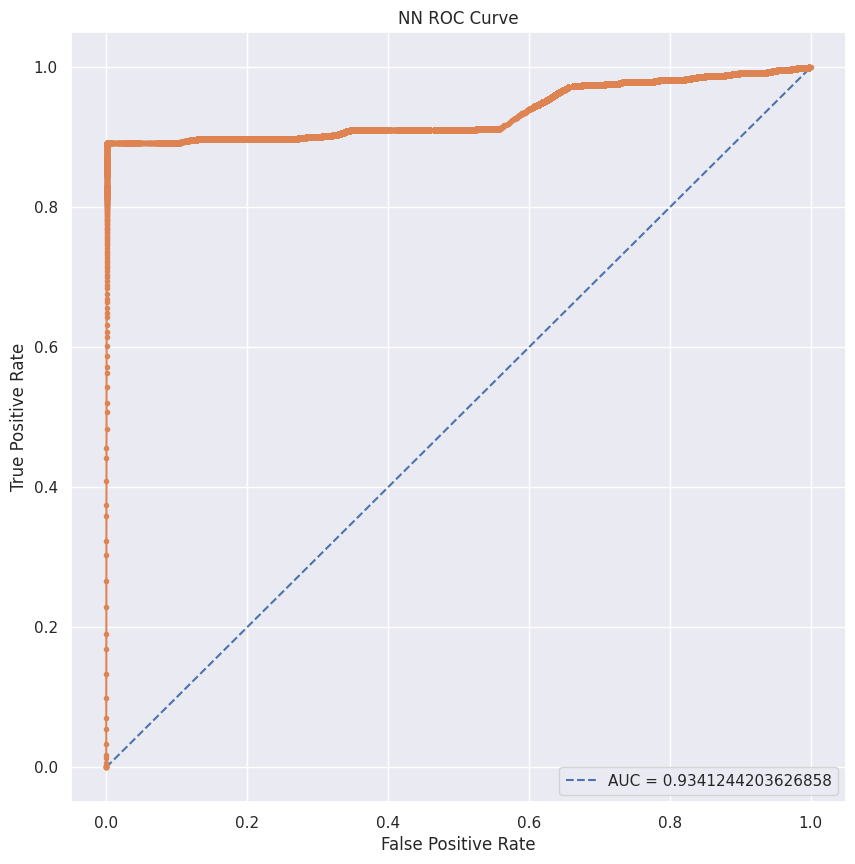

In [148]:
# ROC curve on neural network
from sklearn.metrics import roc_curve
y_pred_nn=model.predict(X_unseen)
FPR,TPR,thresh=roc_curve(y_unseen,y_pred_nn)
optimal_proba_cutoff_nn=sorted(list(zip(np.abs(TPR-FPR),thresh)),key=lambda i: i[0],reverse=True)[0][1]
print("opt_thresh_prob",optimal_proba_cutoff_nn)

#print(classification_report(y_test,roc_predictions))
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_unseen, y_pred_nn)}") # plot random curve

plt.plot(FPR, TPR, marker=".")
plt.title("NN ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [151]:
# Results from NN after tuning & using optimal threshold on unseen data - will discard it from choosing a champion model
y_unseen_pred=[1 if i>optimal_proba_cutoff_nn else 0 for i in model.predict(X_unseen)]
print(classification_report(y_unseen,y_unseen_pred))
y_pred_train=[1 if i>optimal_proba_cutoff_nn else 0 for i in model.predict(X_train)]
print(classification_report(y_train,y_pred_train))

296/296 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8410
           1       0.99      0.58      0.73      1052

    accuracy                           0.95      9462
   macro avg       0.97      0.79      0.85      9462
weighted avg       0.95      0.95      0.95      9462

21912/21912 [==============================] - 23s 1ms/step
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    591666
         1.0       0.99      0.89      0.94    109515

    accuracy                           0.98    701181
   macro avg       0.99      0.94      0.96    701181
weighted avg       0.98      0.98      0.98    701181



### Hyperparameter tuning

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [154]:
#Logistic Regression
print(classifier_lg.get_params())
params=[{"solver":["lbfgs", "liblinear", "newton-c  g"],"class_weight":["balanced",{0:0.4,1:0.6}],"penalty":["l1","l2","elasticnet"]}]
        
cv_grid_lg=GridSearchCV(classifier_lg,param_grid=params,scoring="f1",cv=10,n_jobs=-1)
cv_grid_lg.fit(X_train,y_train)


{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'class_weight': ['balanced', {0: 0.4, 1: 0.6}],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['lbfgs', 'liblinear', 'newton-c  g']}],
             scoring='f1')

In [155]:
# Randaom Forest
from sklearn.model_selection import GridSearchCV
#'criterion':['gini','entropy']
#"max_depth":[4,5,6],"class_weight":["balanced",{0:0.40,1:0.6}]
classifier_RF=RandomForestClassifier()
print(classifier_RF.get_params())
params=[{"n_estimators":[100,200],"min_samples_split":[3,4,5],"max_features":[None]}]
cv_grid_rf=GridSearchCV(classifier_RF,param_grid=params,scoring="f1",n_jobs=-1,cv=5)
cv_grid_rf.fit(X_train,y_train)


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_features': [None],
                          'min_samples_split': [3, 4, 5],
                          'n_estimators': [100, 200]}],
             scoring='f1')

In [54]:
# XGboost
from xgboost import XGBClassifier
classifier_XGB=XGBClassifier()
params=[{"n_estimators":[50,75,100],"max_depth":[3,4,5,6],"learning_rate":[0.001,0.01,0.1],'reg_alpha':[1,5,10],'reg_lambda':[0,5,10],"class_weight":["balanced",{0:0.4,1:0.6}]}]
cv_grid_xgb=GridSearchCV(classifier_XGB,param_grid=params,scoring="f1",cv=10,n_jobs=-1)


In [15]:
cv_grid_xgb.fit(X_train,y_train)
print(cv_grid_xgb.best_score_,cv_grid_xgb.best_params_)


[18:55:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.



0.9414170645595845 {'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75, 'reg_alpha': 5, 'reg_lambda': 0}


In [0]:
# Light GBM
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
classifier_lgbm=LGBMClassifier()
#,"learning_rate":[0.1,0.001,0.005]
#"reg_alpha":[0,1,5],"reg_lambda":[1,5]
params=[{"boosting_type":["goss"], "n_estimators":[50,75,100],"max_depth":[4,5,6],\
"class_weight":["balanced",{1:0.6,0:0.4}]}]
cv_grid_lgbm=GridSearchCV(classifier_lgbm,param_grid=params,scoring="f1",n_jobs=-1,cv=10)
cv_grid_lgbm.fit(X_train,y_train)
print(cv_grid_lgbm.best_score_,cv_grid_lgbm.best_params_)

### Re-training

In [162]:
cv_grid_lg.best_params_

{'class_weight': {0: 0.4, 1: 0.6}, 'penalty': 'l2', 'solver': 'liblinear'}

In [163]:
# Logistic
print(list(cv_grid_lg.best_params_.values()))
classifier_lg=LogisticRegression(**cv_grid_lg.best_params_)
classifier_lg.fit(X_train,y_train)

[{0: 0.4, 1: 0.6}, 'l2', 'liblinear']


LogisticRegression(class_weight={0: 0.4, 1: 0.6}, solver='liblinear')

In [178]:
print(classification_report(y_train,classifier_lg.predict(X_train)))
print(classification_report(y_unseen,classifier_lg.predict(X_unseen)))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    591666
         1.0       0.99      0.87      0.93    109515

    accuracy                           0.98    701181
   macro avg       0.98      0.94      0.96    701181
weighted avg       0.98      0.98      0.98    701181

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8410
           1       0.99      0.53      0.69      1052

    accuracy                           0.95      9462
   macro avg       0.97      0.76      0.83      9462
weighted avg       0.95      0.95      0.94      9462



In [0]:
# Saving_model object LG
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
file_path = os.path.join(folder_path,'Logistic_model_tuned.sav')
pickle.dump(classifier_lg, open(file_path, 'wb'))
 

In [164]:
# Random forest
classifier_RF=RandomForestClassifier(**cv_grid_rf.best_params_)
classifier_RF.fit(X_train,y_train)

RandomForestClassifier(max_features=None, min_samples_split=5)

In [177]:
print(classification_report(y_train,classifier_RF.predict(X_train)))
print(classification_report(y_unseen,classifier_RF.predict(X_unseen)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    591666
         1.0       0.99      0.94      0.96    109515

    accuracy                           0.99    701181
   macro avg       0.99      0.97      0.98    701181
weighted avg       0.99      0.99      0.99    701181

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      8410
           1       0.80      0.75      0.77      1052

    accuracy                           0.95      9462
   macro avg       0.88      0.86      0.87      9462
weighted avg       0.95      0.95      0.95      9462



In [0]:
# Saving_model object RF
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
file_path = os.path.join(folder_path,'Random_forest_tuned'.sav')
pickle.dump(classifier_RF, open(file_path, 'wb'))

In [81]:
# XGBoost
cv_grid_xgb.best_params_={'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75, 'reg_alpha': 5, 'reg_lambda': 0}
re_xgb=XGBClassifier(**cv_grid_xgb.best_params_)
re_xgb.fit(X_train,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, ...)

In [82]:
print(classification_report(y_train,re_xgb.predict(X_train)))
print(classification_report(y_unseen,re_xgb.predict(X_unseen)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    591666
           1       0.99      0.90      0.94    109515

    accuracy                           0.98    701181
   macro avg       0.99      0.95      0.97    701181
weighted avg       0.98      0.98      0.98    701181

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8410
           1       0.99      0.74      0.85      1052

    accuracy                           0.97      9462
   macro avg       0.98      0.87      0.92      9462
weighted avg       0.97      0.97      0.97      9462



In [0]:
# Saving_model object XGB
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
file_path = os.path.join(folder_path,'Classifier_xgb_tuned.sav')
pickle.dump(re_xgb, open(file_path, 'wb'))

In [169]:
#lightgbm
classifier_lgbm=LGBMClassifier(**cv_grid_lgbm.best_params_)
classifier_lgbm.fit(X_train,y_train)


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Number of positive: 109515, number of negative: 591666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1479
[LightGBM] [Info] Number of data points in the train set: 701181, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156186 -> initscore=-1.686881
[LightGBM] [Info] Start training from score -1.686881


LGBMClassifier(random_state=1, verbose_eval=False)

In [175]:
print(classification_report(y_train,classifier_lgbm.predict(X_train)))
print(classification_report(y_unseen,classifier_lgbm.predict(X_unseen)))

[LightGBM] [Warning] Unknown parameter: verbose_eval
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    591666
         1.0       0.99      0.90      0.94    109515

    accuracy                           0.98    701181
   macro avg       0.99      0.95      0.97    701181
weighted avg       0.98      0.98      0.98    701181

[LightGBM] [Warning] Unknown parameter: verbose_eval
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8410
           1       0.99      0.74      0.85      1052

    accuracy                           0.97      9462
   macro avg       0.98      0.87      0.92      9462
weighted avg       0.97      0.97      0.97      9462



In [0]:
# Saving_model object LGBM
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
file_path = os.path.join(folder_path,'Light_GBM_tuned.sav')
pickle.dump(classifier_lgbm, open(file_path, 'wb'))

### ROC curve

[LightGBM] [Warning] Unknown parameter: verbose_eval
LG threshold : 0.4140290298670913


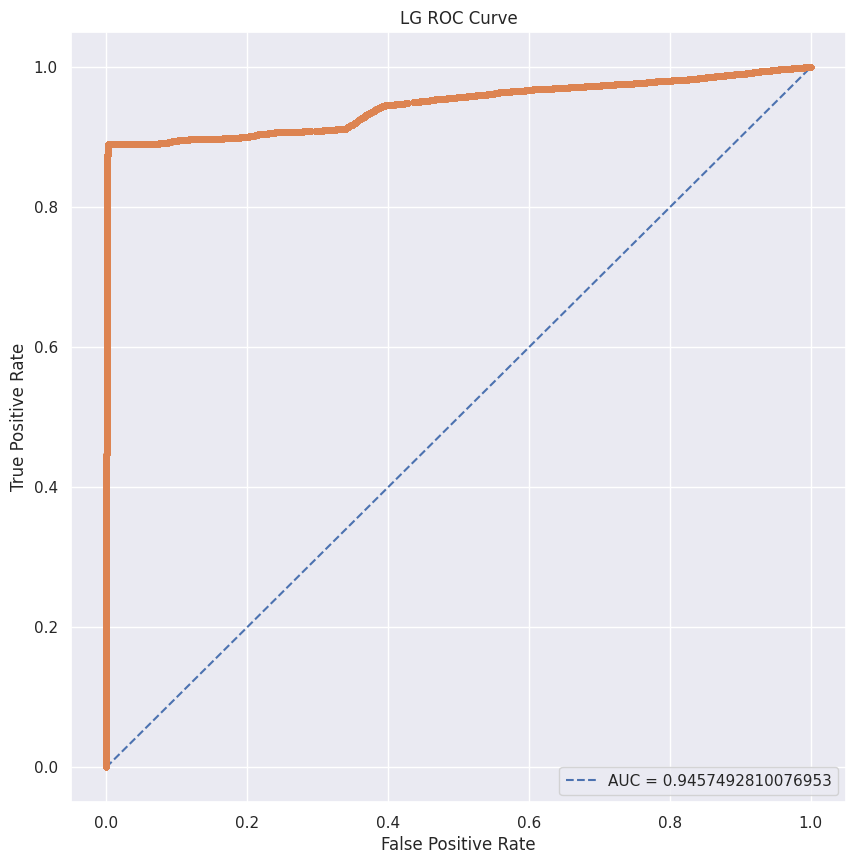

RF threshold : 0.9072475197788409


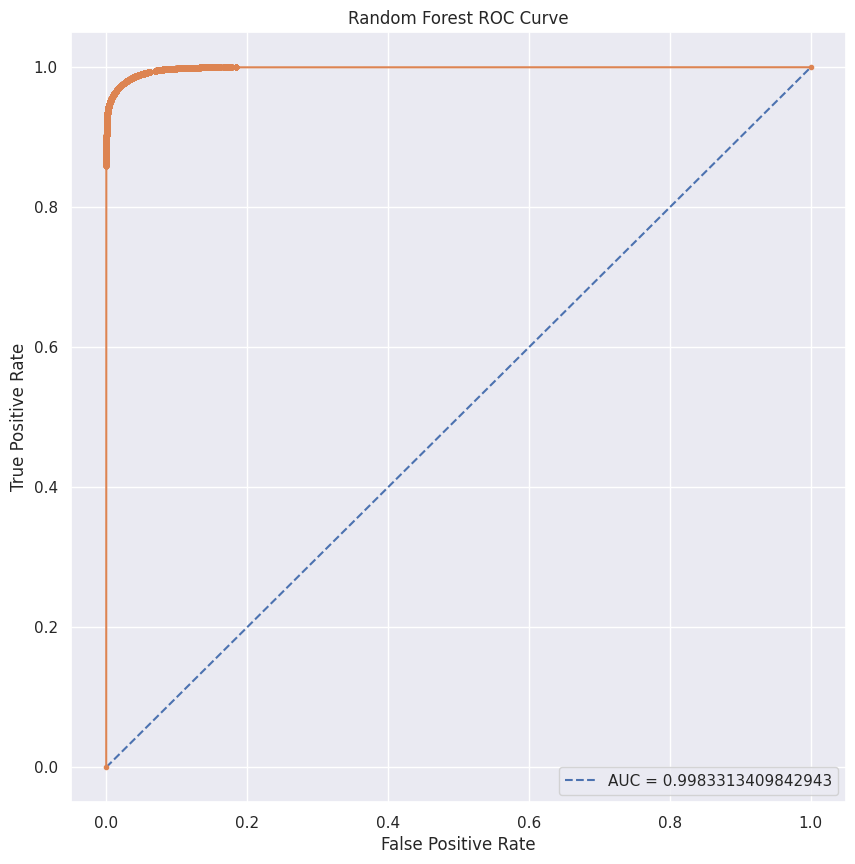

[LightGBM] [Warning] Unknown parameter: verbose_eval
Light GBM : 0.1218210215478194


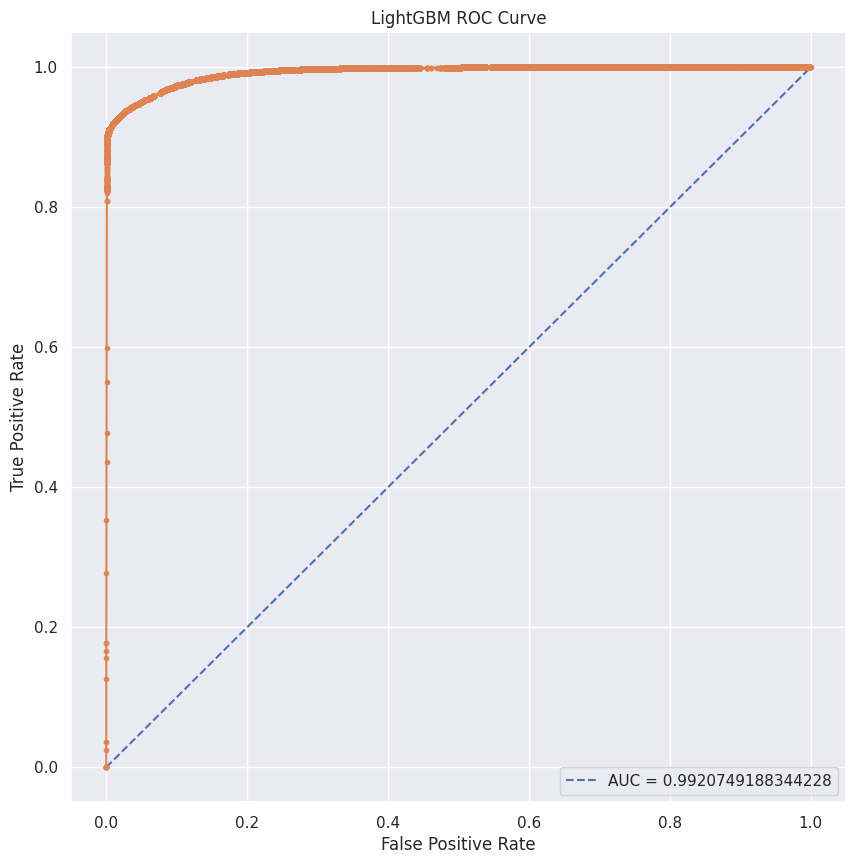

XG Boost threshold : 0.1761869085143564


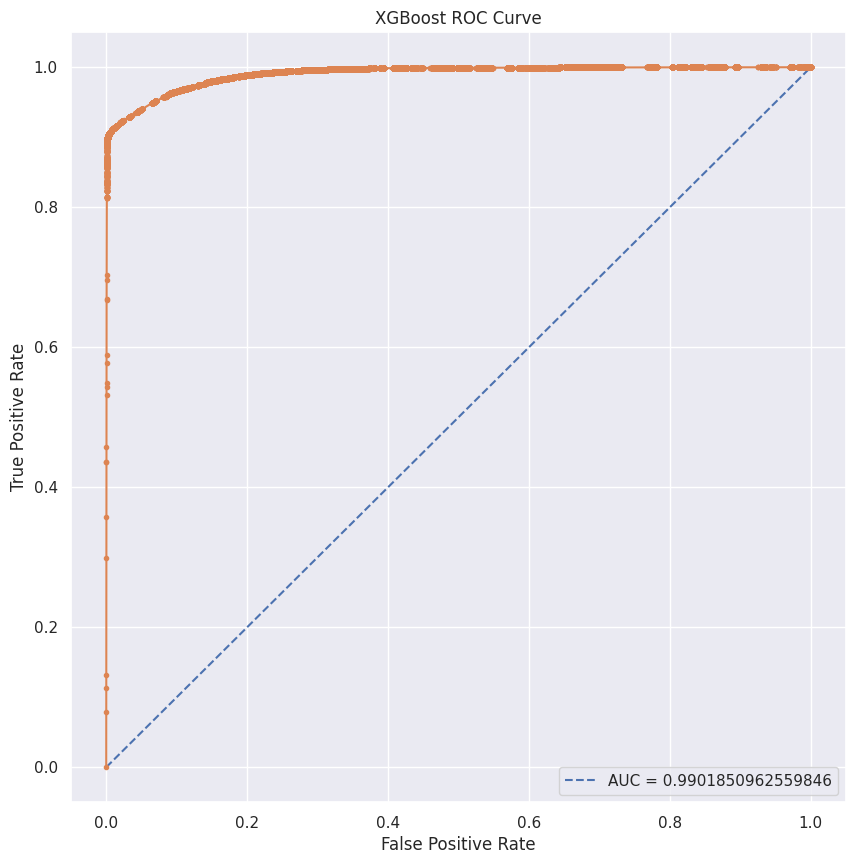

In [173]:
thresh_dict={}
# Logistic Regression
predicted_proba=classifier_lg.predict_proba(X_test)
FPR, TPR, proba = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["LG"]=optimal_proba_cutoff
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in classifier_lgbm.predict_proba(X_test)[:, -1]]
print("LG threshold :", optimal_proba_cutoff)
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(FPR, TPR, marker=".")
plt.title("LG ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()


#Random forest
predicted_proba=classifier_RF.predict_proba(X_test)
FPR, TPR, thres = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["Random forest"]=optimal_proba_cutoff

print("RF threshold :", optimal_proba_cutoff)
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(FPR, TPR, marker=".")
plt.title("Random Forest ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()
# LightGBM
predicted_proba=classifier_lgbm.predict_proba(X_test)
FPR, TPR, proba = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["LightGBM"]=optimal_proba_cutoff
print("Light GBM :", optimal_proba_cutoff)
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(FPR,TPR, marker=".")
plt.title("LightGBM ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

#XG Boost
predicted_proba=re_xgb.predict_proba(X_test)
FPR, TPR, thres = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thresh_dict["XG Boost"]=optimal_proba_cutoff
print("XG Boost threshold :", optimal_proba_cutoff)
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(FPR, TPR, marker=".")
plt.title("XGBoost ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()




### PRC curve

In [0]:
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay
thres_dict_prc ={} 

# Logistic Regression
Pre,Rec,th=precision_recall_curve(y_test,predicted_proba=classifier_lg.predict_proba(X_test)[:,-1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thres_dict_prc["LG"]=optimal_proba_cutoff
print("LG threshold :", optimal_proba_cutoff)
plt.figure()
disp = PrecisionRecallDisplay(precision=Pre, recall=Rec)
disp.plot()
plt.plot(Pre, Rec, marker=".")
#plt.title("LG ROC Curve")
#plt.ylabel("True Positive Rate")
#plt.xlabel("False Positive Rate")
#plt.legend(loc="lower right")
#plt.show()



# Random Forest
Pre,Rec,th=precision_recall_curve(y_test,predicted_proba=classifier_RF.predict_proba(X_test)[:,-1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thres_dict_prc["RF"]=optimal_proba_cutoff
print("RF threshold :", optimal_proba_cutoff)
plt.figure()
disp = PrecisionRecallDisplay(precision=Pre, recall=Rec)
disp.plot()
plt.plot(Pre, Rec, marker=".")



# XGBoost
Pre,Rec,th=precision_recall_curve(y_test,predicted_proba=re_xgb.predict_proba(X_test)[:,-1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thres_dict_prc["XGB"]=optimal_proba_cutoff
print("XGB threshold :", optimal_proba_cutoff)
plt.figure()
disp = PrecisionRecallDisplay(precision=Pre, recall=Rec)
disp.plot()
plt.plot(Pre, Rec, marker=".")





# LightGBM
Pre,Rec,th=precision_recall_curve(y_test,predicted_proba=classifier_lgbm.predict_proba(X_test)[:,-1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), proba)), key=lambda i: i[0], reverse=True)[0][1]
thres_dict_prc["LGBM"]=optimal_proba_cutoff
print("LGBM threshold :", optimal_proba_cutoff)
plt.figure()
disp = PrecisionRecallDisplay(precision=Pre, recall=Rec)
disp.plot()
plt.plot(Pre, Rec, marker=".")



In [171]:
class model_prob:
    def __init__(self):
        self.dict=thresh_dict
prob=model_prob()
file_path=os.path.join(folder_path,"opt_thres.sav")
pickle.dump(model_prob,open(file_path,"wb"))
x=pickle.load(open(file_path,"rb"))

# Champion Model Selection 

In [174]:


print("LG")
y_unseen_pred=[1 if i> thresh_dict["LG"] else 0 for i in  classifier_lg.predict_proba(X_unseen)[:, 1] ]
y_train_pred=[1 if i> thresh_dict["LG"] else 0 for i in  classifier_lg.predict_proba(X_train)[:, 1]]
print(classification_report(y_train,y_train_pred))
print(classification_report(y_unseen,y_unseen_pred))
print("RF")
y_unseen_pred=[1 if i> thresh_dict["Random forest"] else 0 for i in  classifier_RF.predict_proba(X_unseen)[:, 1] ]
y_train_pred=[1 if i> thresh_dict["Random forest"] else 0 for i in  classifier_lg.predict_proba(X_train)[:, 1]]

print(classification_report(y_train,y_train_pred))
print(classification_report(y_unseen,y_unseen_pred))
print("LGBM")
y_unseen_pred=[1 if i> thresh_dict["LightGBM"] else 0 for i in  classifier_lgbm.predict_proba(X_unseen)[:, 1] ]
y_train_pred=[1 if i> thresh_dict["LightGBM"] else 0 for i in  classifier_lg.predict_proba(X_train)[:, 1]]

print(classification_report(y_train,y_train_pred))
print(classification_report(y_unseen,y_unseen_pred))
print("XGB")
y_unseen_pred=[1 if i> thresh_dict["XG Boost"] else 0 for i in  re_xgb.predict_proba(X_unseen)[:, 1] ]
y_train_pred=[1 if i> thresh_dict["XG Boost"] else 0 for i in  classifier_lg.predict_proba(X_train)[:, 1]]
print(classification_report(y_train,y_train_pred))
print(classification_report(y_unseen,y_unseen_pred))




LG
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    591666
         1.0       0.99      0.89      0.93    109515

    accuracy                           0.98    701181
   macro avg       0.98      0.94      0.96    701181
weighted avg       0.98      0.98      0.98    701181

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8410
           1       0.99      0.58      0.73      1052

    accuracy                           0.95      9462
   macro avg       0.97      0.79      0.85      9462
weighted avg       0.95      0.95      0.95      9462

RF
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93    591666
         1.0       1.00      0.15      0.26    109515

    accuracy                           0.87    701181
   macro avg       0.93      0.58      0.59    701181
weighted avg       0.88      0.87      0.82    701181

             

In [0]:
for j in list(results.keys()):
    if results["XGBoost"]>= results[j]:
        model_object=classifier_XGB
    else :
        l=list(results.values())
        max_score_ind=l.index(max(l))
        model_name=list(results.keys())[max_score_ind]
        model_object=classifier[model_name]

In [0]:
# save the model to disk
folder_path=dataiku.Folder("Name Screening notebooks").get_path()
file_path = os.path.join(folder_path,'finalized_model_(siamese & fuzzy(only_orginal_name).sav')
pickle.dump(model_object, open(file_path, 'wb'))
 
# some time later...

# load the model from disk
loaded_model = pickle.load(open(file_path, 'rb'))
loaded_model.predict(X_test_2)
#result = loaded_model.score(X_test, Y_test)
#print(result)


# Feature Importance

DOR : Obtained 5 features out of 14 features using Recursive Feature elimination technqiue .
Obtained importance of every feature using XGBoost feature importance technique with criteria as weight.At first iteration removed Final_Nysiis_mlipns_score & Final_Meta_mlipns_score. Noted that AUC score for training data was kept constant (0.99 approx).
In 2nd interation trained a new model with new set of features and again obatined feature importance . This time removed Final_Soundex_bisim_score & Final Saps_sim_score. The model performance remained static (0.99 approx).
In 3rd iteration removed Final_Meta_bisim_score & Nysiis_strcmp_score. The model performance reamined static
In 4th iteration removed Final_Lig_sim_score. The performance shifted to 0.98
In 5 th iteration removed Final_Phonex_bisim_score. The performance remained 0.98
In 6th iteration we came to 5 features retaining only Nysiis_bisim_score.

In [65]:
# XG Boost built-in algorithm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

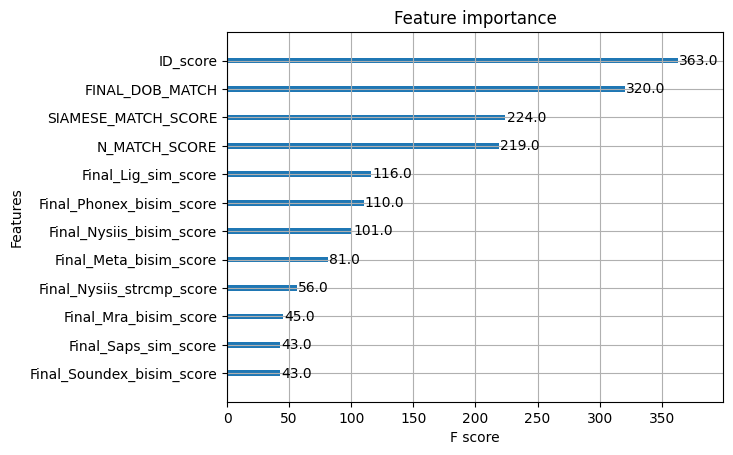

In [75]:
from xgboost import plot_importance
plot_importance(re_xgb)
plt.show()

### Feature Imp using Weight

### 1st iteration

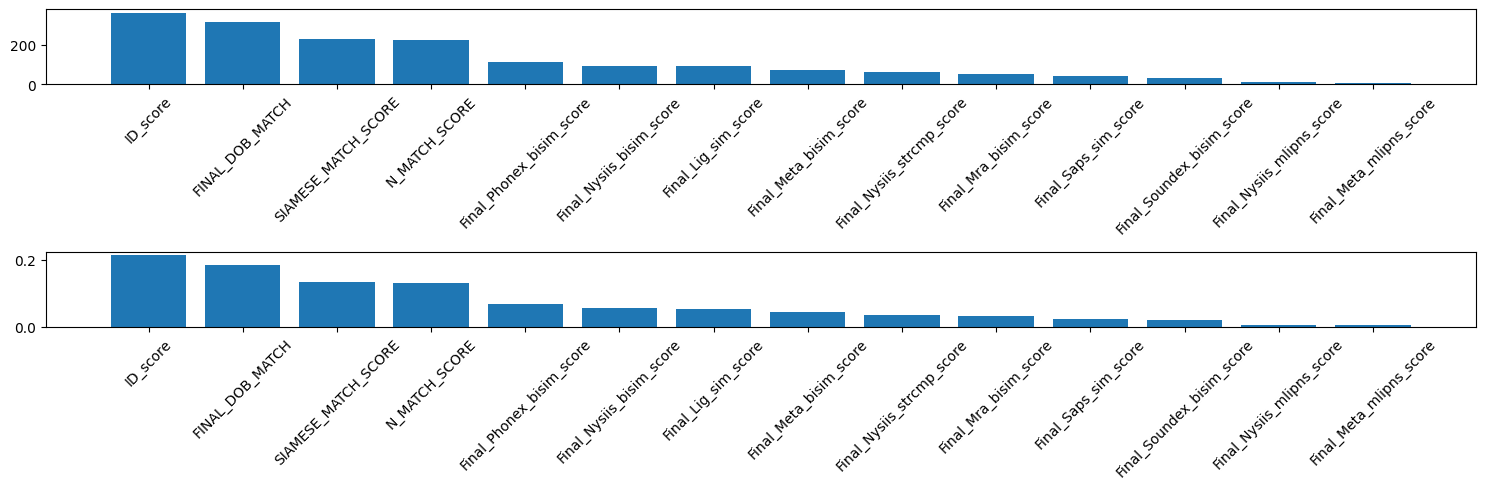

In [84]:
fi = pd.DataFrame({'Feature_names':X_train.columns,'Weight_Imp':list(re_xgb.get_booster().get_score(importance_type="weight").values())})


fi["Percent_Weight_Imp"]=[i/ sum(fi["Weight_Imp"].values) for i in fi["Weight_Imp"]]
fi.sort_values(by='Weight_Imp',ascending=False,inplace=True)
fig,ax=plt.subplots(nrows=2,ncols=1)
plt.sca(ax[0])
ax[0].bar(fi["Feature_names"],fi["Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.sca(ax[1])
ax[1].bar(fi["Feature_names"],fi["Percent_Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.gcf().set_size_inches(15, 5)
fig.tight_layout()
plt.show()

In [85]:
fi[["Feature_names",'Weight_Imp',"Percent_Weight_Imp"]]

Feature_names  Weight_Imp  Percent_Weight_Imp
1                    ID_score       366.0            0.213660
0             FINAL_DOB_MATCH       316.0            0.184472
2         SIAMESE_MATCH_SCORE       230.0            0.134267
3               N_MATCH_SCORE       225.0            0.131349
10   Final_Phonex_bisim_score       115.0            0.067134
9    Final_Nysiis_bisim_score        94.0            0.054874
12        Final_Lig_sim_score        92.0            0.053707
6      Final_Meta_bisim_score        74.0            0.043199
8   Final_Nysiis_strcmp_score        61.0            0.035610
13      Final_Mra_bisim_score        52.0            0.030356
11       Final_Saps_sim_score        40.0            0.023351
4   Final_Soundex_bisim_score        33.0            0.019264
7   Final_Nysiis_mlipns_score         9.0            0.005254
5     Final_Meta_mlipns_score         6.0            0.003503

### 2nd Iteration

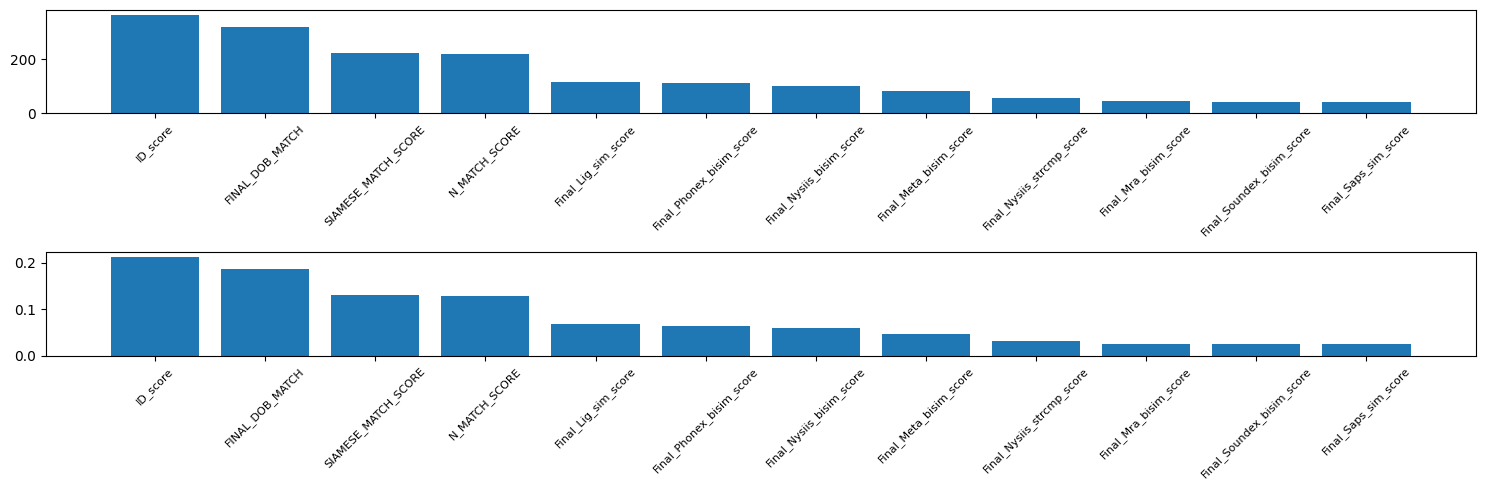

In [87]:
X_1=X_train[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE",'Final_Soundex_bisim_score',
             'Final_Meta_bisim_score', 'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 
             'Final_Phonex_bisim_score', 'Final_Saps_sim_score', 'Final_Lig_sim_score', 'Final_Mra_bisim_score']]
y_1=df_train["V_RESOLUTION"]


cv_grid_xgb.best_params_={'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75, 'reg_alpha': 5, 'reg_lambda': 0}
re_xgb=XGBClassifier(**cv_grid_xgb.best_params_)





re_xgb.fit(X_1,y_1)

#y_pred_unseen=re_xgb.predict(X_unseen)
classification_report(y_train,y_pred_train)

fi_1 = pd.DataFrame({'Feature_names':X_1.columns,'Weight_Imp':list(re_xgb.get_booster().get_score(importance_type="weight").values())})
fi_1["Percent_Weight_Imp"]=[i/ sum(fi_1["Weight_Imp"].values) for i in fi_1["Weight_Imp"]]
fi_1.sort_values(by='Weight_Imp',ascending=False,inplace=True)
fig,ax=plt.subplots(nrows=2,ncols=1)
plt.sca(ax[0])
ax[0].bar(fi_1["Feature_names"],fi_1["Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.sca(ax[1])
ax[1].bar(fi_1["Feature_names"],fi_1["Percent_Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.gcf().set_size_inches(15, 5)
fig.tight_layout()
plt.show()







In [88]:
fi_1[["Feature_names",'Weight_Imp',"Percent_Weight_Imp"]]

Feature_names  Weight_Imp  Percent_Weight_Imp
1                    ID_score       363.0            0.210924
0             FINAL_DOB_MATCH       320.0            0.185938
2         SIAMESE_MATCH_SCORE       224.0            0.130157
3               N_MATCH_SCORE       219.0            0.127252
10        Final_Lig_sim_score       116.0            0.067403
8    Final_Phonex_bisim_score       110.0            0.063916
7    Final_Nysiis_bisim_score       101.0            0.058687
5      Final_Meta_bisim_score        81.0            0.047066
6   Final_Nysiis_strcmp_score        56.0            0.032539
11      Final_Mra_bisim_score        45.0            0.026148
4   Final_Soundex_bisim_score        43.0            0.024985
9        Final_Saps_sim_score        43.0            0.024985

In [90]:
y_pred_1=re_xgb.predict(X_1)
print(classification_report(y_1,y_pred_1))
X_unseen_1=df_test[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE",'Final_Soundex_bisim_score',
                    'Final_Meta_bisim_score', 'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 
                    'Final_Phonex_bisim_score', 'Final_Saps_sim_score', 'Final_Lig_sim_score', 'Final_Mra_bisim_score']]
y_unseen_1=df_test["V_RESOLUTION"]
y_pred_unseen_1=re_xgb.predict(X_unseen_1)


print(classification_report(y_unseen,y_pred_unseen_1))




              precision    recall  f1-score   support

           0       0.98      1.00      0.99    591666
           1       0.99      0.90      0.94    109515

    accuracy                           0.98    701181
   macro avg       0.99      0.95      0.97    701181
weighted avg       0.98      0.98      0.98    701181

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8410
           1       0.99      0.74      0.85      1052

    accuracy                           0.97      9462
   macro avg       0.98      0.87      0.92      9462
weighted avg       0.97      0.97      0.97      9462



XG Boost threshold : 0.12961917


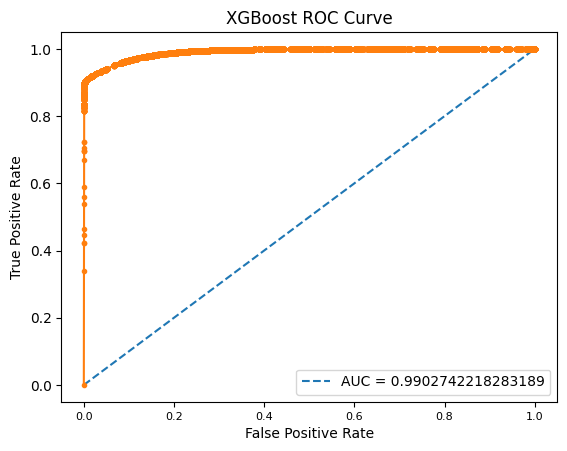

In [98]:
predicted_proba=re_xgb.predict_proba(X_1)
FPR, TPR, thres = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), thres)), key=lambda i: i[0], reverse=True)[0][1]

print("XG Boost threshold :", optimal_proba_cutoff)
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(FPR, TPR, marker=".")
plt.title("XGBoost ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 3rd Iteration

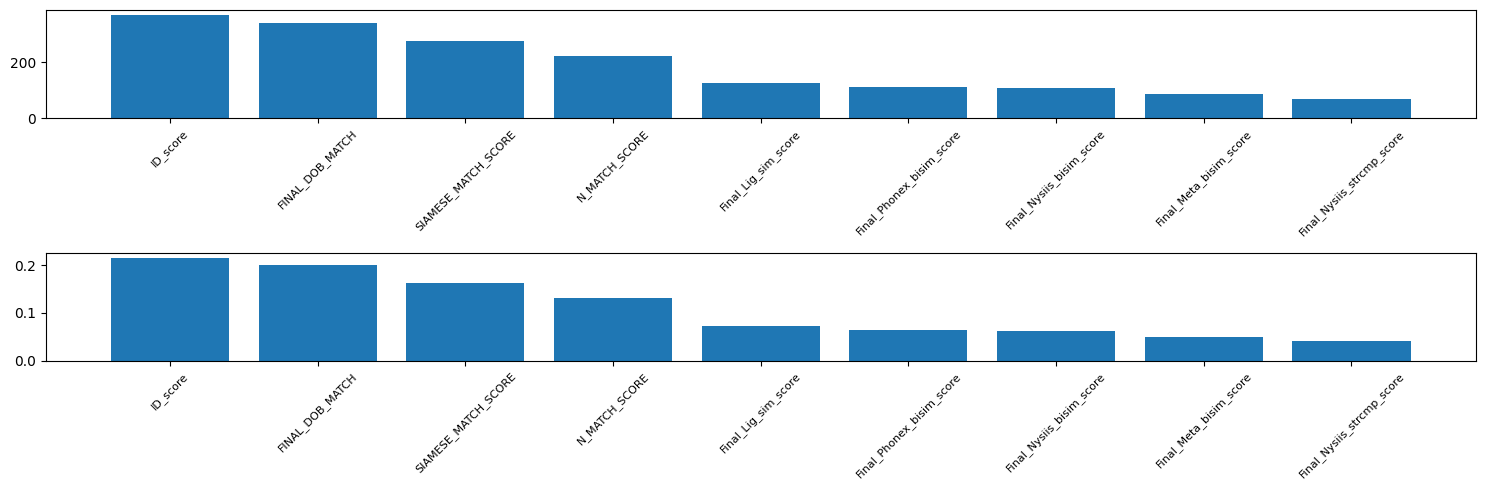

In [104]:
X_2=X_train[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE",'Final_Meta_bisim_score', 
             'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Lig_sim_score']]
y_2=df_train[["V_RESOLUTION"]]
cv_grid_xgb.best_params_={'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75, 'reg_alpha': 5, 'reg_lambda': 0}
re_xgb=XGBClassifier(**cv_grid_xgb.best_params_)





re_xgb.fit(X_2,y_2)

fi_2 = pd.DataFrame({'Feature_names':X_2.columns,'Weight_Imp':list(re_xgb.get_booster().get_score(importance_type="weight").values())})
fi_2["Percent_Weight_Imp"]=[i/ sum(fi["Weight_Imp"].values) for i in fi_2["Weight_Imp"]]
fi_2.sort_values(by='Weight_Imp',ascending=False,inplace=True)
fig,ax=plt.subplots(nrows=2,ncols=1)
plt.sca(ax[0])
ax[0].bar(fi_2["Feature_names"],fi_2["Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.sca(ax[1])
ax[1].bar(fi_2["Feature_names"],fi_2["Percent_Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.gcf().set_size_inches(15, 5)
fig.tight_layout()
plt.show()







In [106]:
fi_2[["Feature_names",'Weight_Imp',"Percent_Weight_Imp"]]

Feature_names  Weight_Imp  Percent_Weight_Imp
1                   ID_score       369.0            0.215412
0            FINAL_DOB_MATCH       341.0            0.199066
2        SIAMESE_MATCH_SCORE       277.0            0.161705
3              N_MATCH_SCORE       223.0            0.130181
8        Final_Lig_sim_score       125.0            0.072971
7   Final_Phonex_bisim_score       111.0            0.064799
6   Final_Nysiis_bisim_score       108.0            0.063047
4     Final_Meta_bisim_score        87.0            0.050788
5  Final_Nysiis_strcmp_score        70.0            0.040864

XG Boost threshold : 0.12247387


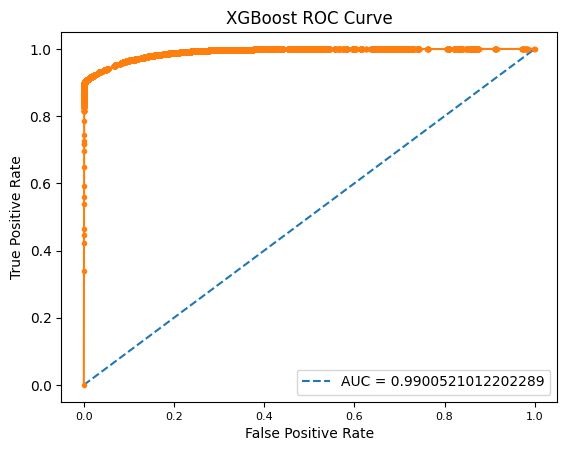

In [110]:
predicted_proba=re_xgb.predict_proba(X_2)
FPR, TPR, thres = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), thres)), key=lambda i: i[0], reverse=True)[0][1]

print("XG Boost threshold :", optimal_proba_cutoff)
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(FPR, TPR, marker=".")
plt.title("XGBoost ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [109]:
y_pred_2=re_xgb.predict(X_2)
print(classification_report(y_2,y_pred_2))
X_unseen_2=df_test[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE",'Final_Meta_bisim_score', 'Final_Nysiis_strcmp_score', 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Lig_sim_score']]

y_unseen_2=df_test["V_RESOLUTION"]
y_pred_unseen_2=re_xgb.predict(X_unseen_2)


print(classification_report(y_unseen,y_pred_unseen_2))




              precision    recall  f1-score   support

           0       0.98      1.00      0.99    591666
           1       0.99      0.90      0.94    109515

    accuracy                           0.98    701181
   macro avg       0.99      0.95      0.97    701181
weighted avg       0.98      0.98      0.98    701181

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8410
           1       0.99      0.74      0.85      1052

    accuracy                           0.97      9462
   macro avg       0.98      0.87      0.92      9462
weighted avg       0.97      0.97      0.97      9462



### 4 th Iteration

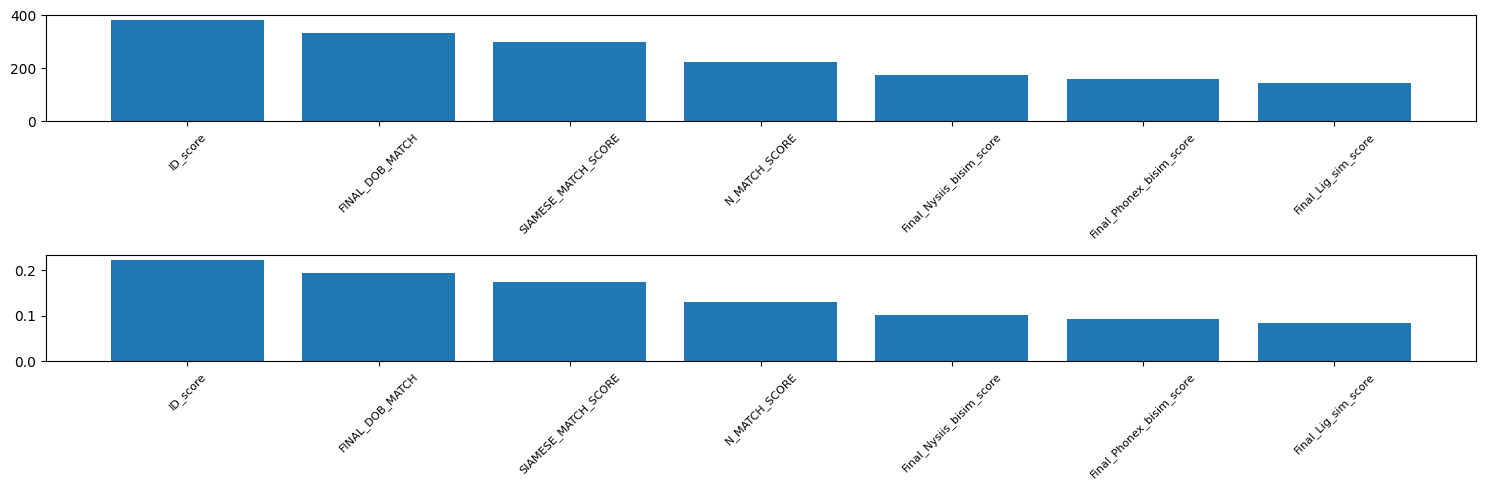

In [132]:
X_3=X_train[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE", 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Lig_sim_score']]
y_3=df_train[["V_RESOLUTION"]]
cv_grid_xgb.best_params_={'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75, 'reg_alpha': 5, 'reg_lambda': 0}
re_xgb=XGBClassifier(**cv_grid_xgb.best_params_)





re_xgb.fit(X_3,y_3)

fi_3 = pd.DataFrame({'Feature_names':X_3.columns,'Weight_Imp':list(re_xgb.get_booster().get_score(importance_type="weight").values())})
fi_3["Percent_Weight_Imp"]=[i/ sum(fi["Weight_Imp"].values) for i in fi_3["Weight_Imp"]]
fi_3.sort_values(by='Weight_Imp',ascending=False,inplace=True)
fig,ax=plt.subplots(nrows=2,ncols=1)
plt.sca(ax[0])
ax[0].bar(fi_3["Feature_names"],fi_3["Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.sca(ax[1])
ax[1].bar(fi_3["Feature_names"],fi_3["Percent_Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.gcf().set_size_inches(15, 5)
fig.tight_layout()
plt.show()


In [133]:
fi_3[["Feature_names",'Weight_Imp',"Percent_Weight_Imp"]]

Feature_names  Weight_Imp  Percent_Weight_Imp
1                  ID_score       382.0            0.223001
0           FINAL_DOB_MATCH       334.0            0.194980
2       SIAMESE_MATCH_SCORE       298.0            0.173964
3             N_MATCH_SCORE       223.0            0.130181
4  Final_Nysiis_bisim_score       173.0            0.100992
5  Final_Phonex_bisim_score       159.0            0.092820
6       Final_Lig_sim_score       145.0            0.084647

In [134]:
y_pred_3=re_xgb.predict(X_3)
print(classification_report(y_3,y_pred_3))
X_unseen_3=df_test[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE", 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score', 'Final_Lig_sim_score']]

y_unseen_3=df_test["V_RESOLUTION"]
y_pred_unseen_3=re_xgb.predict(X_unseen_3)


print(classification_report(y_unseen_3,y_pred_unseen_3))



              precision    recall  f1-score   support

           0       0.98      1.00      0.99    591666
           1       0.99      0.90      0.94    109515

    accuracy                           0.98    701181
   macro avg       0.99      0.95      0.97    701181
weighted avg       0.98      0.98      0.98    701181

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8410
           1       0.99      0.74      0.85      1052

    accuracy                           0.97      9462
   macro avg       0.98      0.87      0.92      9462
weighted avg       0.97      0.97      0.97      9462



XG Boost threshold : 0.12483941


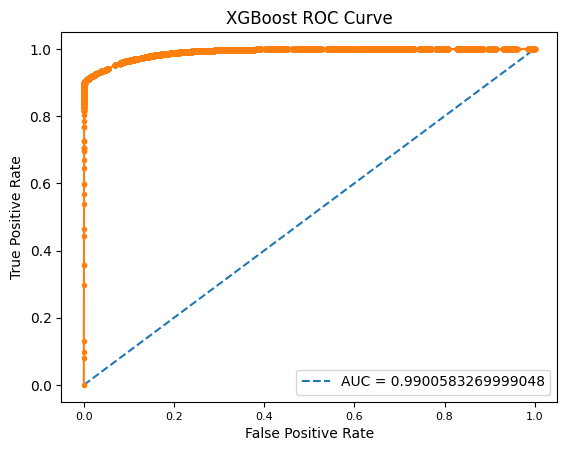

In [135]:
predicted_proba=re_xgb.predict_proba(X_3)
FPR, TPR, thres = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), thres)), key=lambda i: i[0], reverse=True)[0][1]

print("XG Boost threshold :", optimal_proba_cutoff)
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(FPR, TPR, marker=".")
plt.title("XGBoost ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

### 5 iteration

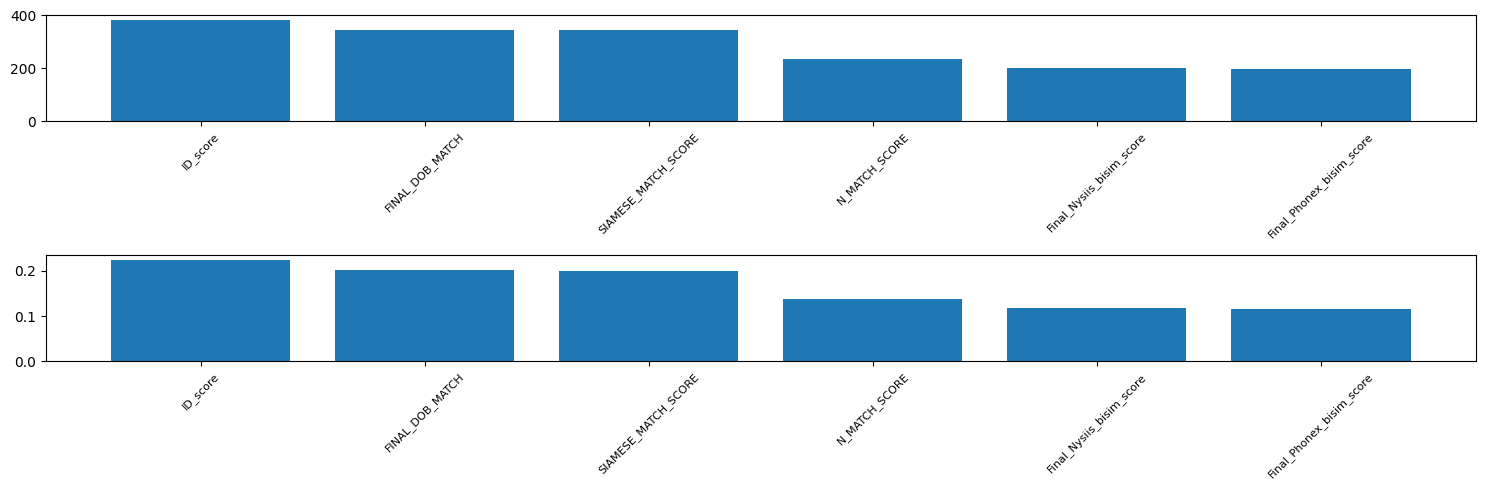

In [122]:
X_4=X_train[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE", 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score']]
y_4=df_train[["V_RESOLUTION"]]
cv_grid_xgb.best_params_={'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75, 'reg_alpha': 5, 'reg_lambda': 0}
re_xgb=XGBClassifier(**cv_grid_xgb.best_params_)





re_xgb.fit(X_4,y_4)

fi_4 = pd.DataFrame({'Feature_names':X_4.columns,'Weight_Imp':list(re_xgb.get_booster().get_score(importance_type="weight").values())})
fi_4["Percent_Weight_Imp"]=[i/ sum(fi["Weight_Imp"].values) for i in fi_4["Weight_Imp"]]
fi_4.sort_values(by='Weight_Imp',ascending=False,inplace=True)
fig,ax=plt.subplots(nrows=2,ncols=1)
plt.sca(ax[0])
ax[0].bar(fi_4["Feature_names"],fi_4["Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.sca(ax[1])
ax[1].bar(fi_4["Feature_names"],fi_4["Percent_Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.gcf().set_size_inches(15, 5)
fig.tight_layout()
plt.show()


In [136]:
fi_4[["Feature_names",'Weight_Imp',"Percent_Weight_Imp"]]

Feature_names  Weight_Imp  Percent_Weight_Imp
1                  ID_score       383.0            0.223584
0           FINAL_DOB_MATCH       343.0            0.200234
2       SIAMESE_MATCH_SCORE       342.0            0.199650
3             N_MATCH_SCORE       234.0            0.136602
4  Final_Nysiis_bisim_score       201.0            0.117338
5  Final_Phonex_bisim_score       198.0            0.115587

In [127]:
y_pred_4=re_xgb.predict(X_4)
print(classification_report(y_4,y_pred_4))
X_unseen_4=df_test[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE", 'Final_Nysiis_bisim_score', 'Final_Phonex_bisim_score']]

y_unseen_4=df_test["V_RESOLUTION"]
y_pred_unseen_4=re_xgb.predict(X_unseen_4)


print(classification_report(y_unseen_4,y_pred_unseen_4))



              precision    recall  f1-score   support

           0       0.98      1.00      0.99    591666
           1       0.99      0.90      0.94    109515

    accuracy                           0.98    701181
   macro avg       0.99      0.95      0.97    701181
weighted avg       0.98      0.98      0.98    701181

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8410
           1       0.99      0.74      0.85      1052

    accuracy                           0.97      9462
   macro avg       0.98      0.87      0.92      9462
weighted avg       0.97      0.97      0.97      9462



XG Boost threshold : 0.12581685


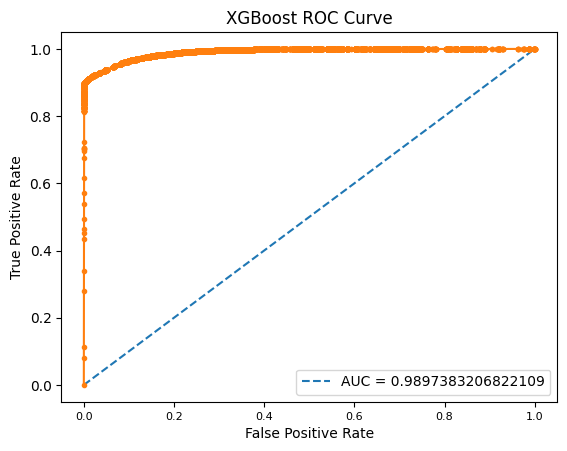

In [130]:
predicted_proba=re_xgb.predict_proba(X_4)
FPR, TPR, thres = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), thres)), key=lambda i: i[0], reverse=True)[0][1]

print("XG Boost threshold :", optimal_proba_cutoff)
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(FPR, TPR, marker=".")
plt.title("XGBoost ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [0]:
### 6 iteration

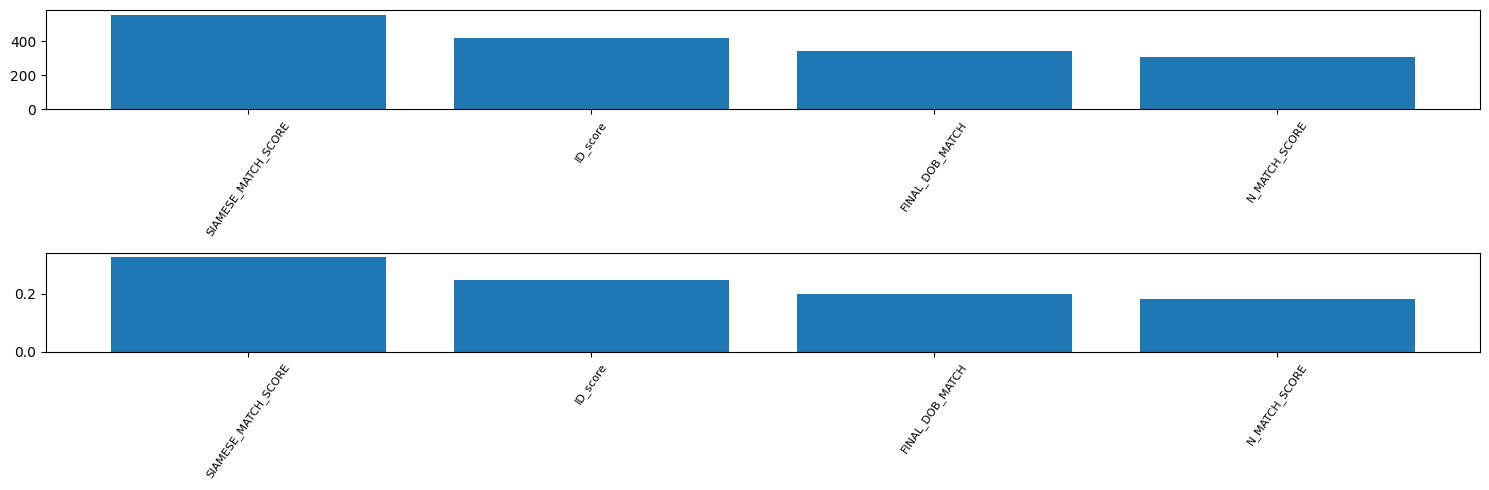

In [139]:
X_5=X_train[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE"]]
y_5=df_train[["V_RESOLUTION"]]
cv_grid_xgb.best_params_={'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75, 'reg_alpha': 5, 'reg_lambda': 0}
re_xgb=XGBClassifier(**cv_grid_xgb.best_params_)





re_xgb.fit(X_5,y_5)

fi_5 = pd.DataFrame({'Feature_names':X_5.columns,'Weight_Imp':list(re_xgb.get_booster().get_score(importance_type="weight").values())})
fi_5["Percent_Weight_Imp"]=[i/ sum(fi["Weight_Imp"].values) for i in fi_5["Weight_Imp"]]
fi_5.sort_values(by='Weight_Imp',ascending=False,inplace=True)
fig,ax=plt.subplots(nrows=2,ncols=1)
plt.sca(ax[0])
ax[0].bar(fi_5["Feature_names"],fi_5["Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=55)

plt.sca(ax[1])
ax[1].bar(fi_5["Feature_names"],fi_5["Percent_Weight_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=55)

plt.gcf().set_size_inches(15, 5)
fig.tight_layout()
plt.show()


In [140]:
fi_5[["Feature_names",'Weight_Imp',"Percent_Weight_Imp"]]

Feature_names  Weight_Imp  Percent_Weight_Imp
2  SIAMESE_MATCH_SCORE       557.0            0.325161
1             ID_score       422.0            0.246351
0      FINAL_DOB_MATCH       343.0            0.200234
3        N_MATCH_SCORE       309.0            0.180385

In [141]:
y_pred_5=re_xgb.predict(X_5)
print(classification_report(y_5,y_pred_5))
X_unseen_5=df_test[["FINAL_DOB_MATCH","ID_score","SIAMESE_MATCH_SCORE","N_MATCH_SCORE"]]

y_unseen_5=df_test["V_RESOLUTION"]
y_pred_unseen_5=re_xgb.predict(X_unseen_5)


print(classification_report(y_unseen_5,y_pred_unseen_5))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    591666
           1       0.99      0.90      0.94    109515

    accuracy                           0.98    701181
   macro avg       0.99      0.95      0.97    701181
weighted avg       0.98      0.98      0.98    701181

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8410
           1       0.99      0.74      0.85      1052

    accuracy                           0.97      9462
   macro avg       0.98      0.87      0.92      9462
weighted avg       0.97      0.97      0.97      9462



XG Boost threshold : 0.12876004


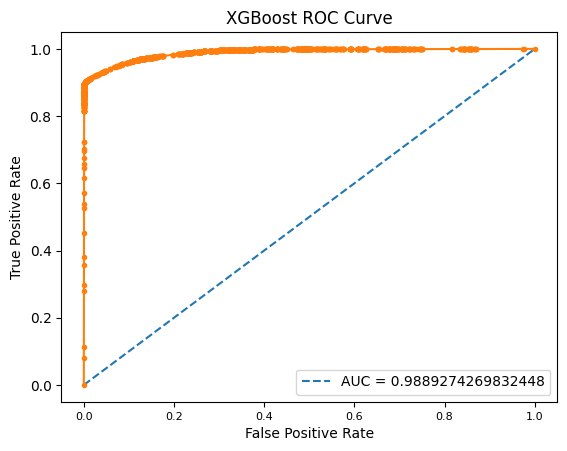

In [142]:
predicted_proba=re_xgb.predict_proba(X_5)
FPR, TPR, thres = roc_curve(y_train, predicted_proba[:, -1])
optimal_proba_cutoff = sorted(list(zip(np.abs(TPR - FPR), thres)), key=lambda i: i[0], reverse=True)[0][1]

print("XG Boost threshold :", optimal_proba_cutoff)
plt.figure()
plt.plot([0,1], [0,1], linestyle="--",label=f"AUC = {roc_auc_score(y_train, predicted_proba[:, -1])}") # plot random curve
plt.plot(FPR, TPR, marker=".")
plt.title("XGBoost ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

### Feature Imp using Total gain

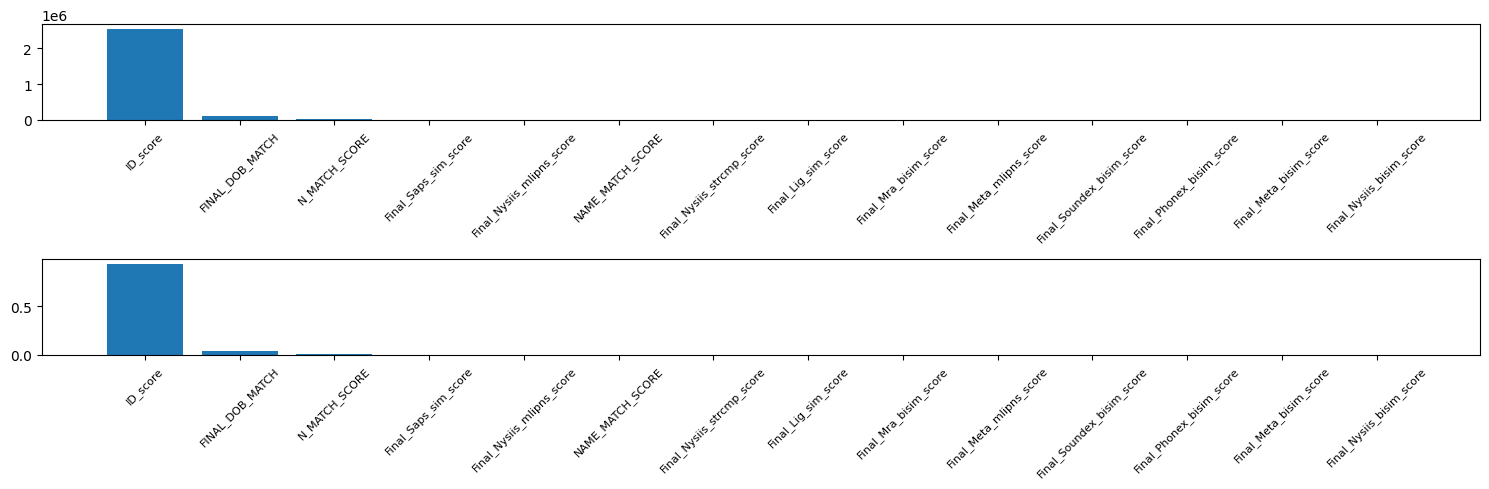

In [23]:
fi['Total_Gain_Imp']=list(re_xgb.get_booster().get_score(importance_type="total_gain").values())
fi["Percent_Total_Gain_Imp"]=[i/sum(fi["Total_Gain_Imp"].values) for i in fi["Total_Gain_Imp"]]
fi.sort_values(by='Total_Gain_Imp',ascending=False,inplace=True)
fig,ax=plt.subplots(nrows=2,ncols=1)
plt.sca(ax[0])
ax[0].bar(fi["Feature_names"],fi["Total_Gain_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)
plt.sca(ax[1])
ax[1].bar(fi["Feature_names"],fi["Percent_Total_Gain_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)
plt.gcf().set_size_inches(15, 5)
fig.tight_layout()
plt.show()

In [24]:
fi[["Feature_names",'Total_Gain_Imp',"Percent_Total_Gain_Imp"]]

Feature_names  Total_Gain_Imp  Percent_Total_Gain_Imp
1                    ID_score    2.544558e+06                0.943621
0             FINAL_DOB_MATCH    9.809519e+04                0.036378
3               N_MATCH_SCORE    3.212909e+04                0.011915
11       Final_Saps_sim_score    4.899947e+03                0.001817
7   Final_Nysiis_mlipns_score    4.297459e+03                0.001594
2            NAME_MATCH_SCORE    3.635894e+03                0.001348
8   Final_Nysiis_strcmp_score    2.082117e+03                0.000772
12        Final_Lig_sim_score    1.755312e+03                0.000651
13      Final_Mra_bisim_score    1.699024e+03                0.000630
5     Final_Meta_mlipns_score    1.407051e+03                0.000522
4   Final_Soundex_bisim_score    7.756492e+02                0.000288
10   Final_Phonex_bisim_score    5.506252e+02                0.000204
6      Final_Meta_bisim_score    4.909141e+02                0.000182
9    Final_Nysiis_bisim_score    2.127014e+02                0.000079

### Feature Imp using Gain

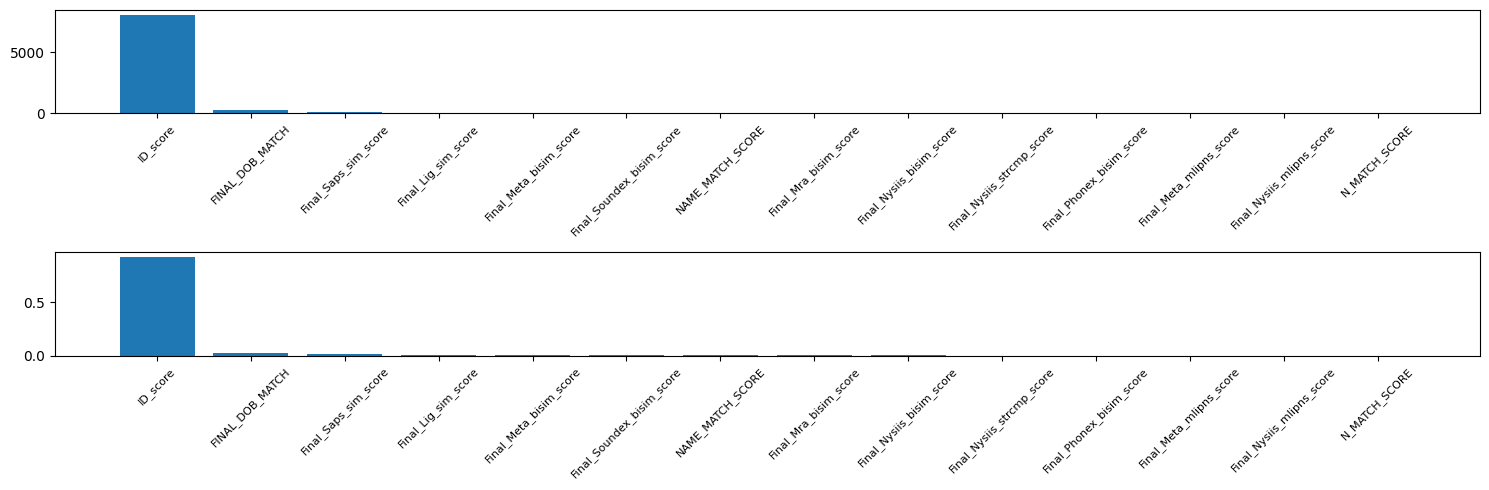

In [25]:
fi ['Gain_Imp']=list(re_xgb.get_booster().get_score(importance_type="gain").values())
fi["Percent_Gain_Imp"]=[i/sum(fi['Gain_Imp'].values) for i in fi['Gain_Imp']]
fi.sort_values(by='Gain_Imp',ascending=False,inplace=True)
fig,ax=plt.subplots(nrows=2,ncols=1)
plt.sca(ax[0])
ax[0].bar(fi["Feature_names"],fi["Gain_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)
plt.sca(ax[1])
ax[1].bar(fi["Feature_names"],fi["Percent_Gain_Imp"])
plt.rc("xtick",labelsize=8)
plt.xticks(rotation=45)

plt.gcf().set_size_inches(15, 5)
fig.tight_layout()
plt.show()

In [26]:
fi[["Feature_names",'Gain_Imp',"Percent_Gain_Imp"]]

Feature_names     Gain_Imp  Percent_Gain_Imp
1                    ID_score  8052.400391          0.915316
0             FINAL_DOB_MATCH   268.019623          0.030466
11       Final_Saps_sim_score   142.795959          0.016232
12        Final_Lig_sim_score    54.546009          0.006200
6      Final_Meta_bisim_score    46.711510          0.005310
4   Final_Soundex_bisim_score    42.608238          0.004843
2            NAME_MATCH_SCORE    35.450241          0.004030
13      Final_Mra_bisim_score    34.133068          0.003880
9    Final_Nysiis_bisim_score    27.058676          0.003076
8   Final_Nysiis_strcmp_score    23.720436          0.002696
10   Final_Phonex_bisim_score    19.391232          0.002204
5     Final_Meta_mlipns_score    18.074720          0.002055
7   Final_Nysiis_mlipns_score    16.685614          0.001897
3               N_MATCH_SCORE    15.808236          0.001797

In [27]:

# Discounting the feature whose importance is less than 25 percentile
percent_total_gain=np.percentile(fi["Percent_Weight_Imp"],25)
percent_weight=np.percentile(fi["Percent_Gain_Imp"],25)
percent_gain=np.percentile(fi["Percent_Total_Gain_Imp"],25)


wei_un_imp=fi[fi["Percent_Weight_Imp"]<=percent_total_gain][["Feature_names","Percent_Weight_Imp"]]
tgain_un_imp=fi[fi["Percent_Total_Gain_Imp"]<=percent_total_gain][["Feature_names","Percent_Total_Gain_Imp"]]
gain_un_imp=fi[fi["Percent_Gain_Imp"]<=percent_total_gain][["Feature_names","Percent_Gain_Imp"]]

In [28]:
set(wei_un_imp["Feature_names"]).intersection(set(tgain_un_imp["Feature_names"])).intersection(set(gain_un_imp["Feature_names"]))

{'Final_Meta_mlipns_score',
 'Final_Nysiis_mlipns_score',
 'Final_Saps_sim_score',
 'Final_Soundex_bisim_score'}

In [29]:
fi.sort_values("Percent_Weight_Imp",ascending=False)["Feature_names"].values
fi.sort_values("Percent_Gain_Imp",ascending=False)["Feature_names"].values
fi.sort_values("Percent_Total_Gain_Imp",ascending=False)["Feature_names"].values
# Discounting the feature whose importance is less than 40 percentile
percent_total_gain=np.percentile(fi["Percent_Weight_Imp"],40)
percent_weight=np.percentile(fi["Percent_Gain_Imp"],40)
percent_gain=np.percentile(fi["Percent_Total_Gain_Imp"],40)


wei_un_imp=fi[fi["Percent_Weight_Imp"]<=percent_total_gain][["Feature_names","Percent_Weight_Imp"]]
tgain_un_imp=fi[fi["Percent_Total_Gain_Imp"]<=percent_total_gain][["Feature_names","Percent_Total_Gain_Imp"]]
gain_un_imp=fi[fi["Percent_Gain_Imp"]<=percent_total_gain][["Feature_names","Percent_Gain_Imp"]]

In [30]:
set(wei_un_imp["Feature_names"]).intersection(set(tgain_un_imp["Feature_names"])).intersection(set(gain_un_imp["Feature_names"]))

{'Final_Meta_mlipns_score',
 'Final_Mra_bisim_score',
 'Final_Nysiis_mlipns_score',
 'Final_Nysiis_strcmp_score',
 'Final_Saps_sim_score',
 'Final_Soundex_bisim_score'}

In [33]:
fi.sort_values("Percent_Weight_Imp",ascending=False)["Feature_names"].values
fi.sort_values("Percent_Gain_Imp",ascending=False)["Feature_names"].values
fi.sort_values("Percent_Total_Gain_Imp",ascending=False)["Feature_names"].values
# Discounting the feature whose importance is less than 40 percentile
percent_total_gain=np.percentile(fi["Percent_Weight_Imp"],60)
percent_weight=np.percentile(fi["Percent_Gain_Imp"],60)
percent_gain=np.percentile(fi["Percent_Total_Gain_Imp"],60)


wei_un_imp=fi[fi["Percent_Weight_Imp"]<=percent_total_gain][["Feature_names","Percent_Weight_Imp"]]
tgain_un_imp=fi[fi["Percent_Total_Gain_Imp"]<=percent_total_gain][["Feature_names","Percent_Total_Gain_Imp"]]
gain_un_imp=fi[fi["Percent_Gain_Imp"]<=percent_total_gain][["Feature_names","Percent_Gain_Imp"]]

In [34]:
set(wei_un_imp["Feature_names"]).intersection(set(tgain_un_imp["Feature_names"])).intersection(set(gain_un_imp["Feature_names"]))

{'Final_Lig_sim_score',
 'Final_Meta_bisim_score',
 'Final_Meta_mlipns_score',
 'Final_Mra_bisim_score',
 'Final_Nysiis_mlipns_score',
 'Final_Nysiis_strcmp_score',
 'Final_Saps_sim_score',
 'Final_Soundex_bisim_score'}

In [183]:
print(re_xgb.get_booster().get_score(importance_type="total_gain"))
print(re_xgb.get_booster().get_score(importance_type="total_cover"))
print(re_xgb.get_booster().get_score(importance_type="gain"))
print(re_xgb.get_booster().get_score(importance_type="cover"))
print(re_xgb.get_booster().get_score(importance_type="weight"))

{'FINAL_DOB_MATCH': 2544558.5, 'ID_score': 98095.1875, 'NAME_MATCH_SCORE': 3635.894287109375, 'N_MATCH_SCORE': 32129.091796875, 'Final_Soundex_bisim_score': 550.625244140625, 'Final_Meta_mlipns_score': 212.70144653320312, 'Final_Meta_bisim_score': 1755.312255859375, 'Final_Nysiis_mlipns_score': 490.9140930175781, 'Final_Nysiis_strcmp_score': 2082.1171875, 'Final_Nysiis_bisim_score': 1699.0238037109375, 'Final_Phonex_bisim_score': 4899.947265625, 'Final_Saps_sim_score': 775.6492309570312, 'Final_Lig_sim_score': 4297.458984375, 'Final_Mra_bisim_score': 1407.0511474609375}
{'FINAL_DOB_MATCH': 3813065.5, 'ID_score': 2433192.0, 'NAME_MATCH_SCORE': 396385.46875, 'N_MATCH_SCORE': 1939368.875, 'Final_Soundex_bisim_score': 40914.7578125, 'Final_Meta_mlipns_score': 25995.1953125, 'Final_Meta_bisim_score': 220368.078125, 'Final_Nysiis_mlipns_score': 42244.03515625, 'Final_Nysiis_strcmp_score': 163499.703125, 'Final_Nysiis_bisim_score': 133854.171875, 'Final_Phonex_bisim_score': 495613.0, 'Final_S

# Feature Attribution

DOR :

In [40]:
import lime
import lime.lime_tabular
import sklearn
from __future__ import print_function
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

In [41]:
iris = load_iris()
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(iris.data, iris.target, train_size=0.80)
#rf = RandomForestClassifier(n_estimators=500)
#rf.fit(train, labels_train)

In [142]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X_train.columns, class_names=y_train.unique(), discretize_continuous=False)

In [118]:
import numpy as np

exp = explainer.explain_instance(X_unseen.loc[0], re_xgb.predict_proba,num_features=4,  top_labels=2)

In [119]:
pd.options.display
print(y_unseen.loc[0])
exp.show_in_notebook(show_table=True, show_all=True)

0


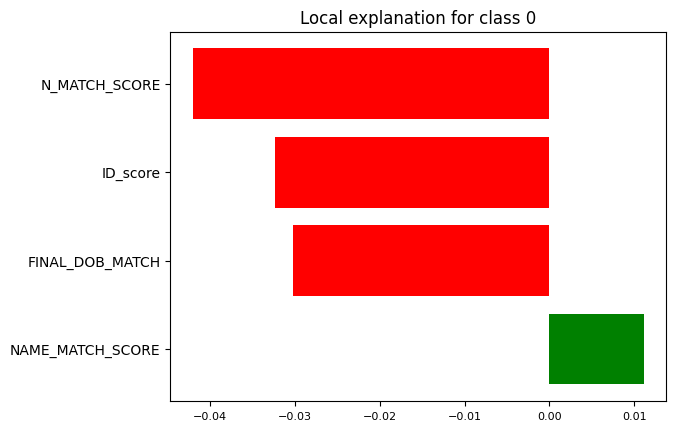

In [127]:
exp.as_pyplot_figure(label=0)

In [68]:
exp.as_map()

{1: [(3, 0.040279569700931314),
  (0, 0.03926420171585586),
  (1, 0.03857054559774872),
  (8, 0.008502056789010747),
  (9, 0.005954568687896812),
  (4, 0.005310246757954705),
  (2, -0.004680763003077746),
  (12, -0.004519441319096899),
  (11, 0.0022524240237577478),
  (6, 0.0021814313740311972)],
 0: [(3, -0.040279569776585096),
  (0, -0.039264201626113805),
  (1, -0.038570545306132256),
  (8, -0.00850205689803167),
  (9, -0.005954568831254381),
  (4, -0.005310246487473918),
  (2, 0.0046807628455589195),
  (12, 0.004519441290370869),
  (11, -0.002252423892656527),
  (6, -0.002181431491363849)]}

In [128]:
y_unseen_pred=re_xgb.predict(X_unseen)
df_test["V_PREDICTION"]=[1 if i>0.5 else 0 for i in y_unseen_pred]

In [130]:
df_test["V_PREDICTION"].loc[1]

0

In [92]:
#pd.options.display.col_width=20
pd.set_option('display.max_colwidth', None)

In [1]:
#[X_unseen.iloc[k,:].apply(lambda x: explainer.explain_instance(x, re_xgb.predict_proba, num_features=4, top_labels=2).as_list(label=int(df_test["V_PREDICTION"][k]))) for k in X_unseen.index ]

In [153]:
[X_unseen.iloc[k-1:k,:].apply(lambda x: explainer.explain_instance(x, re_xgb.predict_proba, num_features=4, top_labels=2).as_list(df_test["V_PREDICTION"].loc[k]),axis=1) for k in X_unseen.index]

[Empty DataFrame
 Columns: [FINAL_DOB_MATCH, ID_score, NAME_MATCH_SCORE, N_MATCH_SCORE, Final_Soundex_bisim_score, Final_Meta_mlipns_score, Final_Meta_bisim_score, Final_Nysiis_mlipns_score, Final_Nysiis_strcmp_score, Final_Nysiis_bisim_score, Final_Phonex_bisim_score, Final_Saps_sim_score, Final_Lig_sim_score, Final_Mra_bisim_score]
 Index: [],
 0    [(N_MATCH_SCORE, -0.044354034477798315), (ID_score, -0.03740673060310962), (FINAL_DOB_MATCH, -0.035734993530548174), (Final_Lig_sim_score, 0.005226822828422108)]
 dtype: object,
 1    [(N_MATCH_SCORE, -0.046099463330318134), (ID_score, -0.04326016600906746), (FINAL_DOB_MATCH, -0.037754274420055314), (Final_Soundex_bisim_score, -0.008012283290197392)]
 dtype: object,
 2    [(N_MATCH_SCORE, -0.0432429110233584), (ID_score, -0.03404349403761398), (FINAL_DOB_MATCH, -0.0290056267242904), (Final_Mra_bisim_score, 0.006733023977064657)]
 dtype: object,
 3    [(N_MATCH_SCORE, -0.04213646540390594), (ID_score, -0.038335165914667346), (FINAL_DOB_MAT

In [125]:
exp.as_list(label=0)

[('N_MATCH_SCORE', -0.04206461798422156),
 ('ID_score', -0.032381754137813565),
 ('FINAL_DOB_MATCH', -0.030259367874488248),
 ('NAME_MATCH_SCORE', 0.011147708526248168)]